In [ ]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random
import pickle
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import matplotlib.lines as lines
from tqdm.notebook import tqdm, trange

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.nn import functional as fnn
from torch.utils import data
from torchvision import transforms

import random
import copy
import time
from math import sqrt, log

# Часть первая: крестики-нолики при помощи Q-обучения


Задача:Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и
ноликов для доски 3х3


In [3]:
# Окружение для игры

class TicTacToe(gym.Env):
    def __init__(self, n_rows=3, n_cols=3, n_win=3):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return 1 #self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        #return (self.getHash(), self.board, self.curTurn)
        return (self.board.copy(), self.curTurn)
    
    def getStateId(self):
        id = 0
        for i, x in enumerate(self.board.reshape(self.n_rows * self.n_cols)):
            if x != 0:
                if x == 1:
                    id += 1 * 3 ** i
                else:
                    id += 2 * 3 ** i

        return id
    
    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        #print('self.curTurn:', self.getStateId(), self.board)
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        state = self.getState()
        self.curTurn = -self.curTurn
        return state, 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
# Модели для табличного обучения, адаптированная для двух игроков (обучается только одна стратегия pi1)
class Control_runner():
    def __init__(self, env, total_episodes = 100000, gamma = 1.00, eps_value = 0.05, eps_value2 = 0.0, alpha_mean = 0.00001, alpha_Q = 0.00001,
                 off_policy = False, verbose = False, window_episodes = 100000, steps_pi_update = 100):
        self.total_episodes = total_episodes
        self.gamma = gamma
        self.alpha_mean = alpha_mean
        self.alpha_Q = alpha_Q
        self.pi1 = self.get_random_policy()
        self.pi2 = self.get_random_policy() # policy for second player
        self.Q = -10 * np.ones((NUMBER_STATES, NUMBER_ACTIONS))
        self.Q_n_visits = np.zeros((NUMBER_STATES, NUMBER_ACTIONS))
        self.mean_total_reward_pi_eps = 0
        self.mean_total_reward_pi = 0
        self.num_total_reward_pi_eps = 0
        self.num_total_reward_pi = 0
        self.mean_rewards_log = []
        self.eps_value = eps_value
        self.eps_value2 = eps_value2
        self.off_policy = off_policy
        self.verbose = verbose
        self.window_episodes = window_episodes
        self.env = env
        self.num_rows = env.n_rows  
        self.num_cols = env.n_cols  
        self.steps_pi_update = steps_pi_update
        
    def generate_next_action(self, env, board, player, clear_expectation = True):
        
        # print(' ')
        #env.printBoard()
        # print(board)
        state_id = env.getStateId()
        if player == 1:
            eps = self.eps_value
        else:
            eps = self.eps_value2    
        
        if np.random.rand() > eps:
            if player == 1:
                next_action = self.pi1[state_id]
            else:
                next_action = self.pi2[state_id]
        else:
            i = 0
            while True and  i < 100:
                next_action = np.random.randint(NUMBER_ACTIONS)
                next_action_xy = self.get_action_by_id(next_action)
                # print(next_action, next_action_xy, board)
                if board[next_action_xy[0], next_action_xy[1]] == 0:
                    if player == 1:
                        if next_action != self.pi1[state_id]:
                            clear_expectation = False
                    else:
                        if next_action != self.pi2[state_id]:
                            clear_expectation = False
                    break
                i += 1
            
        return state_id, next_action, clear_expectation
    
    def get_action_by_id(self, action_id):
        
        return (action_id // self.num_rows, action_id % self.num_rows)
    
    def get_random_policy(self):
        pi = np.random.randint(0, NUMBER_ACTIONS, NUMBER_STATES)

        return pi
    
    def compute_policy_by_Q(self):
        self.pi1 = np.argmax( self.Q, axis=1 )

    def run_episode(self, env):
        
        env.reset()
        observation = env.getState()
        if random.randint(0, 1) == 1: # начинаем играть вторыми
            player = -1
            _, next_action2, _ = self.generate_next_action(env, observation[0], -1)
            observation, _, _, _ = env.step(self.get_action_by_id(next_action2))
        else:
            player = 1
            
        if self.verbose:
            env.printBoard()    
            print('start pos player: {:}'.format(player))    
            
        clear_expectation = True
        states, actions, rewards = [], [], []
        for _ in range(1000):
            state_id, next_action, clear_expectation = self.generate_next_action(env, observation[0], 1, clear_expectation) 
            
            if state_id == check_state:
                plot_board(env, td_runner, showtext=True, verbose=True, fontq=20, fontx=60)
            
            observation, reward, done, info = env.step(self.get_action_by_id(next_action))

            states.append(state_id)
            actions.append(next_action)
            rewards.append(reward)
            
            if self.verbose:
                env.printBoard()   
            
            if done:
                #print('finish on my step')
                reward
                break
                
            _, next_action2, _ = self.generate_next_action(env, observation[0], -1)
            observation, reward2, done, info = env.step(self.get_action_by_id(next_action2))
            rewards[-1] += -reward2 #нужно ли учитывать todo ????
            
            if done:
                #print('finish on enemy step')
                break
        if self.verbose:
            env.printBoard() 
            
        return states, actions, rewards, clear_expectation, player        
    
    def update_Q_on_policy(self, states, actions, rewards):
        pass 

    def update_Q_off_policy(self, states, actions, rewards):
        pass
    
    def run(self, total_episodes = None, gamma = None, eps_value = None, eps_value2 = None, alpha_mean = None, alpha_Q = None, verbose = None):
        
        if total_episodes is not None:
            self.total_episodes = total_episodes
        if gamma is not None:
            self.gamma = gamma            
        if eps_value is not None:
            self.eps_value = eps_value
        if eps_value2 is not None:
            self.eps_value2 = eps_value2         
        if alpha_mean is not None:
            self.alpha_mean = alpha_mean
        if alpha_Q is not None:
            self.alpha_Q = alpha_Q
        self.prob_best_action = 1 - self.eps_value * (NUMBER_ACTIONS-1) / NUMBER_ACTIONS    
        if verbose is not None:
            self.verbose = verbose    
                   
        stats = {-10:0, -1:0, 0:0, 1:0, 10:0,
                 'e_-10':0, 'e_-1':0, 'e_0':0, 'e_1':0, 'e_10':0,
                 'f_-10':0, 'f_-1':0, 'f_0':0, 'f_1':0, 'f_10':0,
                 's_-10':0, 's_-1':0, 's_0':0, 's_1':0, 's_10':0}
        
        for i in range(self.total_episodes):
            states, actions, rewards, clear_expectation, player = self.run_episode(env)
            if self.verbose:
                print(states, actions, rewards, clear_expectation)
                print(rewards[-1])

            self.num_total_reward_pi_eps += 1
            if self.alpha_mean * self.num_total_reward_pi_eps < 1:
                alpha = 1 / self.num_total_reward_pi_eps
            else:
                alpha = self.alpha_mean
            self.mean_total_reward_pi_eps = (1 - alpha) * self.mean_total_reward_pi_eps + alpha * np.sum(rewards)
            
            if rewards[-1] == -1 and chech_bad:
                print(states, actions, rewards, clear_expectation)
                print(rewards[-1])
            
            stats[rewards[-1]] += 1 #save stats
            stats['e_' + str(rewards[-1])] += 1
            if player == 1:
                stats['f_' + str(rewards[-1])] += 1 # Начинает первым
            else:
                stats['s_' + str(rewards[-1])] += 1 # Начинает вторым       
                
            if clear_expectation:
                self.num_total_reward_pi += self.prob_best_action ** (len(actions) - 1)
                if self.alpha_mean * self.num_total_reward_pi < 1:
                    alpha = 1 / self.num_total_reward_pi
                else:
                    alpha = self.alpha_mean
                
                self.mean_total_reward_pi = (1 - alpha) * self.mean_total_reward_pi + alpha * np.sum(rewards)

            self.mean_rewards_log.append(self.mean_total_reward_pi) # оценка по чистой pi стратегии для графиков    
            
            if self.off_policy:
                self.update_Q_off_policy(states, actions, rewards)
            else:
                self.update_Q_on_policy(states, actions, rewards)

            if i % self.steps_pi_update == 0:
                self.compute_policy_by_Q()

            if i % self.window_episodes == self.window_episodes - 1 and self.verbose:
                print(f'step: {i} reward pi_eps: {self.mean_total_reward_pi_eps:2.4f}, reward pi: {self.mean_total_reward_pi:2.4f}')
        
        return stats       

class Td_learning_runner(Control_runner):

    def update_Q_on_policy(self, states, actions, rewards):

        t = len(states) - 1
        self.Q[states[t]][actions[t]] = (1 - self.alpha_Q) * self.Q[states[t]][actions[t]] + \
                        self.alpha_Q * (rewards[t])     
        
        for t in range(len(states)-2, -1, -1):
            self.Q[states[t]][actions[t]] = (1 - self.alpha_Q) * self.Q[states[t]][actions[t]] + \
                            self.alpha_Q * (rewards[t] + self.gamma * self.Q[states[t+1]][actions[t+1]])

    def update_Q_off_policy(self, states, actions, rewards):
        
        check = False
        for i in range(len(states)):
            if states[i] == check_state:
                check = True 
        
        if check:
            for i in range(len(states)):
                print(states[i], actions[i], rewards[i], self.Q[states[i]][actions[i]])
            print(self.Q[check_state])
        
        t = len(states) - 1
        self.Q[states[t]][actions[t]] = (1 - self.alpha_Q) * self.Q[states[t]][actions[t]] + \
                self.alpha_Q * (rewards[t])      
        
        for t in range(len(states)-2, -1, -1):
            self.Q[states[t]][actions[t]] = (1 - self.alpha_Q) * self.Q[states[t]][actions[t]] + \
                    self.alpha_Q * (rewards[t]  + self.gamma * np.max( self.Q[states[t+1]] ))
                
        if check:
            print('after')
            print(self.Q[check_state])
            for i in range(len(states)):
                print(states[i], self.Q[states[i]][actions[i]])
            

In [5]:
def plot_board(env, model, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getStateId(), env.getEmptySpaces()
    if model is not None:
        for i, a in enumerate(actions):
            action_id = a[1] + a[0] * env.n_rows 
            print(a, action_id, model.get_action_by_id(action_id), model.Q[s][action_id])
            Z[a[0], a[1]] = model.Q[s][action_id]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if model is not None:
                action_id = a[1] + a[0] * env.n_rows
                ax.text( a[1] , a[0] , "%.3f" % model.Q[s][action_id], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()


## 3 на 3 игра

In [6]:
# game const and stats
n_rows=3
n_cols=3
n_win=3

NUMBER_STATES = 3 ** (n_rows * n_cols) 
NUMBER_ACTIONS = n_rows * n_cols
print(f'NUMBER_STATES: {NUMBER_STATES}  NUMBER_ACTIONS: {NUMBER_ACTIONS}')

env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)

NUMBER_STATES: 19683  NUMBER_ACTIONS: 9


In [224]:
# Создаем модель (параметры меняем в процессе обучения)
check_state = -1
chech_bad = False
td_runner = Td_learning_runner(env, total_episodes = 10, eps_value = 0.05, eps_value2 = 0.50, 
                               alpha_mean = 0.001, alpha_Q = 0.01,
                 off_policy = True, steps_pi_update = 1001)

In [ ]:
# Тест работы
td_runner.run(total_episodes = 1, alpha_Q = 0.00001, eps_value = 0.30, eps_value2 = 0.50, verbose = True)

In [225]:
log_time = [0]
log_crash = [1]
log_lose = [0]
log_draw = [0]
log_win = [0]
log_rewards = [0]

log_score_vs_random = [-1]
log_lose_vs_random = [1]

Обучаем стратегию игры против соперника ходящего случайно. Критерий нахождения оптимального решения: нет поражений и доля выигрышей стабилизировалась.

In [226]:
# Быстро находим хорошее решение
steps = 200
total_episodes = 5010
test_episodes = 1000
al = 0.5
for step in trange(steps):
    td_runner.pi2 = td_runner.pi1.copy()
    td_runner.mean_rewards_log = []
    st = td_runner.run(total_episodes = total_episodes, alpha_mean = 0.0001, alpha_Q = 0.3, eps_value = 0.3, eps_value2 = 0.5, verbose = False)
    log_time.append(log_time[-1] + total_episodes)
    log_crash.append( (1 - al) * log_crash[-1] + al * st[-10] / total_episodes)
    log_lose.append( (1 - al) * log_lose[-1] + al * st[-1] / total_episodes)
    log_draw.append( (1 - al) * log_draw[-1] + al * st[0] / total_episodes)
    log_win.append( (1 - al) * log_win[-1] + al * st[1] / total_episodes)
    log_rewards.append( (1 - al) * log_rewards[-1] + al * np.mean(td_runner.mean_rewards_log)) 
    
    stats_test = td_runner.run(total_episodes = total_episodes, alpha_mean = 0.000001, alpha_Q = 0.00001, eps_value = 0.0, eps_value2 = 1.0, verbose = False)
    log_score_vs_random.append( (1 - al) * log_score_vs_random[-1] + al * (stats_test[1] - stats_test[-1]) / total_episodes)
    log_lose_vs_random.append( (1 - al) * log_lose_vs_random[-1] + al * (stats_test[-1]) / total_episodes)

(0.0, 1.0)

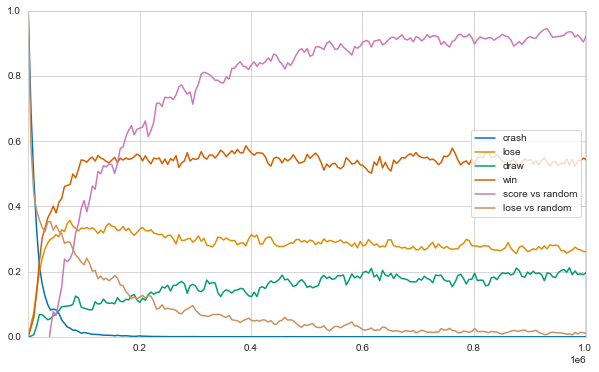

In [227]:
#
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

n = len(log_time)
ax.plot(log_time[:n], log_crash[:n], label="crash", color="C0")
ax.plot(log_time[:n], log_lose[:n],  label="lose", color="C1")
ax.plot(log_time[:n], log_draw[:n],  label="draw", color="C2")
ax.plot(log_time[:n], log_win[:n],  label="win", color="C3")

ax.plot(log_time[:n], log_score_vs_random[:n], label="score vs random", color="C4")
ax.plot(log_time[:n], log_lose_vs_random[:n], label="lose vs random", color="C5")

ax.legend(loc="center right")
ax.set_xlim((1, max(log_time[:n])+1))
ax.set_ylim((0, 1))

In [228]:
# 400 улучшаем стратегий alpha_Q = 0.1, eps_value2 = 0.5
steps = 200
total_episodes = 5010
test_episodes = 1000
al = 0.1
for step in trange(steps):
    td_runner.pi2 = td_runner.pi1.copy()
    td_runner.mean_rewards_log = []
    st = td_runner.run(total_episodes = total_episodes, alpha_mean = 0.0001, alpha_Q = 0.1, eps_value = 0.3, eps_value2 = 0.5, verbose = False)
    log_time.append(log_time[-1] + total_episodes)
    log_crash.append( (1 - al) * log_crash[-1] + al * st[-10] / total_episodes)
    log_lose.append( (1 - al) * log_lose[-1] + al * st[-1] / total_episodes)
    log_draw.append( (1 - al) * log_draw[-1] + al * st[0] / total_episodes)
    log_win.append( (1 - al) * log_win[-1] + al * st[1] / total_episodes)
    log_rewards.append( (1 - al) * log_rewards[-1] + al * np.mean(td_runner.mean_rewards_log)) 
    
    stats_test = td_runner.run(total_episodes = total_episodes, alpha_mean = 0.000001, alpha_Q = 0.00001, eps_value = 0.0, eps_value2 = 1.0, verbose = False)
    log_score_vs_random.append( (1 - al) * log_score_vs_random[-1] + al * (stats_test[1] - stats_test[-1]) / total_episodes)
    log_lose_vs_random.append( (1 - al) * log_lose_vs_random[-1] + al * (stats_test[-1]) / total_episodes)

(0.0, 1.0)

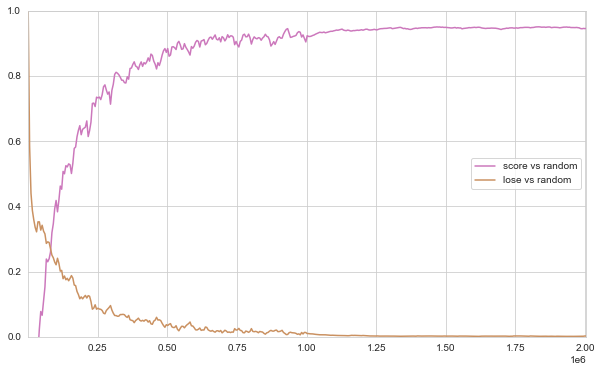

In [229]:
#
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

n = len(log_time)
ax.plot(log_time[:n], log_score_vs_random[:n], label="score vs random", color="C4")
ax.plot(log_time[:n], log_lose_vs_random[:n], label="lose vs random", color="C5")

ax.legend(loc="center right")
ax.set_xlim((1, max(log_time[:n])+1))
ax.set_ylim((0, 1))

(0.0, 0.1)

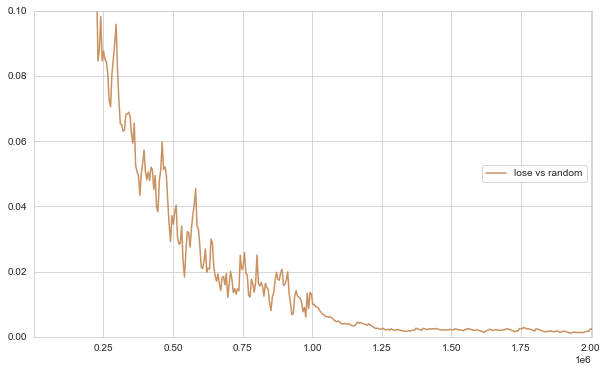

In [231]:
#
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

n = len(log_time)
ax.plot(log_time[:n], log_lose_vs_random[:n], label="lose vs random", color="C5")

ax.legend(loc="center right")
ax.set_xlim((1, max(log_time[:n])+1))
ax.set_ylim((0.0, 0.1))

In [235]:
# alpha_Q = 0.03
steps = 100
total_episodes = 5010
test_episodes = 1000
al = 0.05
for step in trange(steps):
    td_runner.pi2 = td_runner.pi1.copy()
    td_runner.mean_rewards_log = []
    st = td_runner.run(total_episodes = total_episodes, alpha_mean = 0.0001, alpha_Q = 0.03, eps_value = 0.3, eps_value2 = 0.5, verbose = False)
    log_time.append(log_time[-1] + total_episodes)
    log_crash.append( (1 - al) * log_crash[-1] + al * st[-10] / total_episodes)
    log_lose.append( (1 - al) * log_lose[-1] + al * st[-1] / total_episodes)
    log_draw.append( (1 - al) * log_draw[-1] + al * st[0] / total_episodes)
    log_win.append( (1 - al) * log_win[-1] + al * st[1] / total_episodes)
    log_rewards.append( (1 - al) * log_rewards[-1] + al * np.mean(td_runner.mean_rewards_log)) 
    
    stats_test = td_runner.run(total_episodes = total_episodes, alpha_mean = 0.000001, alpha_Q = 0.00001, eps_value = 0.0, eps_value2 = 1.0, verbose = False)
    log_score_vs_random.append( (1 - al) * log_score_vs_random[-1] + al * (stats_test[1] - stats_test[-1]) / total_episodes)
    log_lose_vs_random.append( (1 - al) * log_lose_vs_random[-1] + al * (stats_test[-1]) / total_episodes)

(0.0, 0.1)

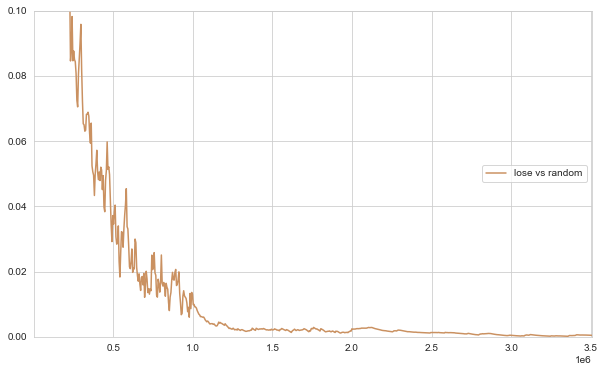

In [236]:
#
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

n = len(log_time)
ax.plot(log_time[:n], log_lose_vs_random[:n], label="lose vs random", color="C5")

ax.legend(loc="center right")
ax.set_xlim((1, max(log_time[:n])+1))
ax.set_ylim((0.0, 0.1))

В итоге доучили до идеальной модели

(0.0, 1.0)

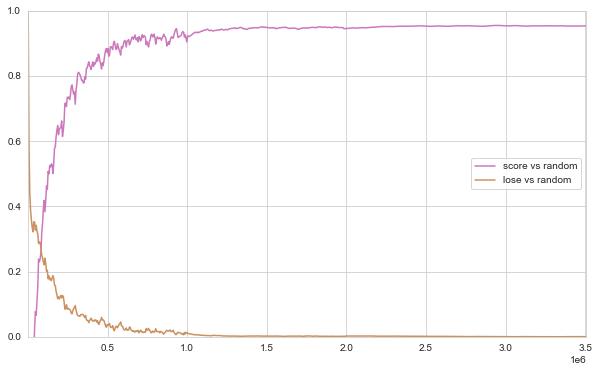

In [237]:
# итого, всесь процесс обучения
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

n = len(log_time)
ax.plot(log_time[:n], log_score_vs_random[:n], label="score vs random", color="C4")
ax.plot(log_time[:n], log_lose_vs_random[:n], label="lose vs random", color="C5")

ax.legend(loc="center right")
ax.set_xlim((1, max(log_time[:n])+1))
ax.set_ylim((0, 1))

Стратегия перестала проигрывать совсем.
Проверка на большом числе случайных игр.

In [238]:
st = td_runner.run(total_episodes = 100000, alpha_mean = 0.001, alpha_Q = 0.000001, eps_value = 0.00, eps_value2 = 1.00, verbose = False)
print("Всего игр: {:} из них побед: {:}, ничьих: {:}, поражений: {:}".format(st[-1] + st[0] + st[1], st[1], st[0], st[-1]))

Всего игр: 100000 из них побед: 95326, ничьих: 4674, поражений: 0


In [239]:
# Сохраняем модель
with open( "data\hw_2_task_3_3.pkl", "wb" ) as f:
    pickle.dump( td_runner, f )
with open( "data\hw_2_task_3_3_log.pkl", "wb" ) as f:
    pickle.dump( (log_time, log_crash, log_lose, log_draw, log_win, log_rewards, log_score_vs_random, log_lose_vs_random), f )

## 4 на 4 игра

Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5

Обучим табличную модель для игры 4 на 4

In [385]:
# game const
n_rows=4
n_cols=4
n_win=4

NUMBER_STATES = 3 ** (n_rows * n_cols) 
NUMBER_ACTIONS = n_rows * n_cols
print(f'NUMBER_STATES: {NUMBER_STATES}  NUMBER_ACTIONS: {NUMBER_ACTIONS}')


env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)

NUMBER_STATES: 43046721  NUMBER_ACTIONS: 16


In [386]:
check_state = -1
chech_bad = False
td_runner = Td_learning_runner(env, total_episodes = 10, eps_value = 0.1, eps_value2 = 0.8, alpha_mean = 0.005, alpha_Q = 0.1,
                 off_policy = True, steps_pi_update = 50000)

# steps_pi_update = 50000 - частота пересчета pi сильно влияет на скорость расчета, так приходиться считать для всех состояний, 
# а их много

In [387]:
log_time = [0]
log_crash = [1]
log_lose = [0]
log_draw = [0]
log_win = [0]
log_rewards = [0]

log_score_vs_random = [-1]
log_lose_vs_random = [1]

In [388]:
steps = 400
total_episodes = 50010
al = 0.2
for step in trange(steps):
    td_runner.pi2 = td_runner.pi1.copy()
    td_runner.mean_rewards_log = []
    st = td_runner.run(total_episodes = total_episodes, alpha_Q = 0.5, eps_value = 0.3, eps_value2 = 0.8, verbose = False)
    log_time.append(log_time[-1] + total_episodes)
    log_crash.append( (1 - al) * log_crash[-1] + al * st[-10] / total_episodes)
    log_lose.append( (1 - al) * log_lose[-1] + al * st[-1] / total_episodes)
    log_draw.append( (1 - al) * log_draw[-1] + al * st[0] / total_episodes)
    log_win.append( (1 - al) * log_win[-1] + al * st[1] / total_episodes)
    log_rewards.append( (1 - al) * log_rewards[-1] + al * np.mean(td_runner.mean_rewards_log)) 
    
    stats_test = td_runner.run(total_episodes = total_episodes, alpha_Q = 0.00001, eps_value = 0.0, eps_value2 = 1.0, verbose = False)
    log_score_vs_random.append( (1 - al) * log_score_vs_random[-1] + al * (stats_test[1] - stats_test[-1] - stats_test[-10]) / total_episodes)
    log_lose_vs_random.append( (1 - al) * log_lose_vs_random[-1] + al * (stats_test[-1]) / total_episodes)

(0.0, 1.0)

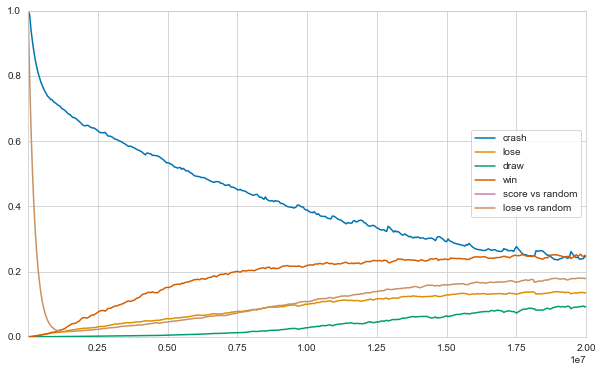

In [389]:
# Процесс обучения
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

n = len(log_time)
ax.plot(log_time[:n], log_crash[:n], label="crash", color="C0")
ax.plot(log_time[:n], log_lose[:n],  label="lose", color="C1")
ax.plot(log_time[:n], log_draw[:n],  label="draw", color="C2")
ax.plot(log_time[:n], log_win[:n],  label="win", color="C3")

ax.plot(log_time[:n], log_score_vs_random[:n], label="score vs random", color="C4")
ax.plot(log_time[:n], log_lose_vs_random[:n], label="lose vs random", color="C5")

ax.legend(loc="center right")
ax.set_xlim((1, max(log_time[:n])+1))
ax.set_ylim((0, 1))

(1.0, 20004001.0)

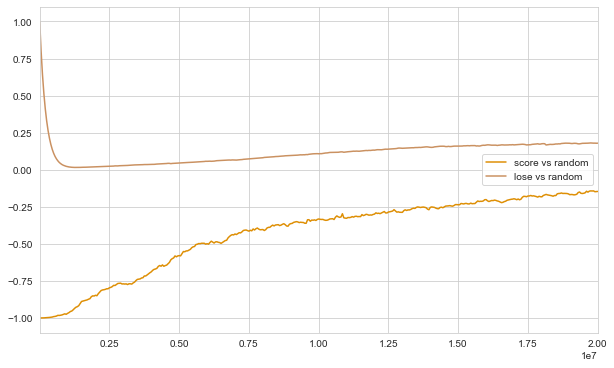

In [392]:
#
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

n = len(log_time)
ax.plot(log_time[:n], log_score_vs_random[:n], label="score vs random", color="C1")
ax.plot(log_time[:n], log_lose_vs_random[:n], label="lose vs random", color="C5")

ax.legend(loc="center right")
ax.set_xlim((1, max(log_time[:n])+1))
#ax.set_ylim((0, 1))

Модель учиться, но намного медленнее

In [1264]:
with open( "data\hw_2_task_4_4.pkl", "wb" ) as f:
    np.save( f, td_runner.Q )
with open( "data\hw_2_task_4_4_log.pkl", "wb" ) as f:
    pickle.dump( (log_time, log_crash, log_lose, log_draw, log_win, log_rewards), f )  

In [394]:
with open( "data\hw_2_task_4_4_v2.pkl", "wb" ) as f:
    np.save( f, td_runner.Q )
with open( "data\hw_2_task_4_4_v2_log.pkl", "wb" ) as f:
    pickle.dump( (log_time, log_crash, log_lose, log_draw, log_win, log_rewards), f )

In [ ]:
with open( "data\hw_2_task_4_4.pkl", "rb" ) as f:
    td_runner = pickle.load(f)
with open( "data\hw_2_task_4_4_log.pkl", "rb" ) as f:    
    log_time, log_crash, log_lose, log_draw, log_win, log_rewards = pickle.load( f )

# Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду
ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в
том числе обобщаться на доски размера побольше).

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов.

4. Реализуйте Double DQN и/или Dueling DQN.


### Классы для обучения 

In [39]:
# Класс для запоминания предыдущийх игр
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [self] * capacity
        self.n_priority = [-10] * capacity
        self.position = 0
        self.full = False
        
    def append(self, data):
        if (self.position + 1) == self.capacity and not self.full:
            self.full = True
            
        self.memory[self.position] = data
        self.n_priority[self.position] = -2000
        self.position = (self.position + 1) % self.capacity
        
    def set_max_size(self, new_capacity):
        if self.capacity < new_capacity:
            memory = [self] * new_capacity
            n_priority = [-10] * new_capacity
            
            used_size = self.capacity if self.full else self.position
            memory[:used_size] = self.memory[:used_size]
            n_priority[:used_size] = self.n_priority[:used_size]
            
            self.memory = memory
            self.n_priority = n_priority
            self.capacity = new_capacity
            self.full = False
        else:
            pass
    
    def clear_old(self):
        # t = time.time()
        used_size = self.capacity if self.full else self.position
        i_pos = 0
        for i in range(used_size):
            if self.n_priority[i] >= 0 or self.n_priority[i] == -2000:
                if i_pos < i:
                    self.n_priority[i_pos] = self.n_priority[i]
                    self.memory[i_pos] = self.memory[i]
                    self.n_priority[i] = -1
                i_pos += 1
            else:
                self.n_priority[i] = -1
        self.position = (i_pos) % self.capacity  
        self.full = (self.position + 1 == self.capacity)
        # print(f"clear_not_old time: {time.time()-t}")
        
    def __len__(self):
        return len(self.memory)
    
    def __iter__(self):
        if self.full:
            return iter(zip(self.memory, self.n_priority))
        else:
            return iter(zip(self.memory[:self.position], self.n_priority[:self.position]))

In [40]:
class TwoLayersModel(nn.Module):
    def __init__(self, num_rows = 3, num_col = 3, num_neuron = 100):
        super(TwoLayersModel, self).__init__()
        # self.conv1 = nn.Conv2d(1, 6, 3)
        
        self.fc1 = nn.Linear(num_rows * num_col * 2, num_neuron, bias=True)
        #self.fc2 = nn.Linear(100, 100, bias=True)
        self.last_layer = nn.Linear(num_neuron, num_rows * num_col, bias=True)
        
    def forward(self, x):
        
        x = x.view(-1, self.num_flat_features(x))
        x = fnn.relu(self.fc1(x))
        #x = fnn.relu(self.fc2(x))
        return self.last_layer(x)
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features    

In [41]:
class HistoryDataset(data.Dataset):
    def __init__(self, buffer, nrow, ncol, num_repeat=1):
        super(HistoryDataset, self).__init__()
        self.buffer = buffer
        self.num_repeat = num_repeat
        lenData = len(self.buffer)
        
        self.arr_rand = np.random.rand(lenData)

        states = torch.zeros((lenData, 2, nrow, ncol))
        rewards = torch.zeros((lenData, 1))
        actions = torch.zeros(lenData, dtype=torch.int32)
        
        for i, ((state, action, reward, next_states), n_priority) in enumerate(self.buffer):
            states[i, :, :, :] = state
            rewards[i] = reward
            actions[i] = action
        
        self.buffer.n_priority = [item - 1 for item in self.buffer.n_priority]
        self.n_priority = np.array(self.buffer.n_priority)    
            
        self.full_states = states  
        self.full_actions = actions
        self.full_rewards = rewards
        
    def get_subset(self, split="train"):
        split_idxs = self.arr_rand < 0.8
        if split == "train":
            idxs = split_idxs
        elif split == "val":
            idxs = ~split_idxs
        else:
            idxs = np.arange(0, self.full_states.shape[0])
            
        self.states = self.full_states[idxs]
        self.rewards = self.full_rewards[idxs]
        self.actions = self.full_actions[idxs]
        
        return self
        
    def sef_priority(self, net):
        net.eval()

        states = self.full_states
        rewards = self.full_rewards
        actions = self.full_actions
        with torch.no_grad():
            pred_Q = net(states).cpu()
            pred_rewards = get_reward_by_action(pred_Q, actions)

        self.delta_Q = torch.abs(pred_rewards - rewards)
        q = dataset.delta_Q.numpy()
        qn = self.num_repeat * np.array(20 * q / q.max() + 1, dtype=np.int)
        
        self.buffer.n_priority = [item if item > -1000 else int(qn[i]) for i, item in enumerate(self.buffer.n_priority)]
        
        self.buffer.n_priority = [item - 1 for item in self.buffer.n_priority]
        self.n_priority = np.array(self.buffer.n_priority)  
        
        good_inds = np.squeeze(self.n_priority >= 0)
        
        #print('good: {:}'.format(np.sum(good_inds)))
        self.full_states = self.full_states[good_inds, :, :, :]
        self.full_rewards = self.full_rewards[good_inds, :]
        self.full_actions = self.full_actions[good_inds]
        
        self.arr_rand = np.random.rand(self.full_states.shape[0])
        
    def __getitem__(self, idx):
        sample = {}
        sample["states"] = self.states[idx]
        sample["rewards"] = self.rewards[idx]
        sample["actions"] = self.actions[idx]
        
        return sample

    def __len__(self):
        return len(self.states)
    
def get_reward_by_action(pred_Q_actions, actions):
    pred_rewards = torch.zeros((len(actions), 1))
    for i, action in enumerate(actions):
        pred_rewards[i] = pred_Q_actions[i, action.item()]
        
    return pred_rewards  

def get_reward_by_action2(pred_Q_actions, actions, rewards):
    pred_rewards = pred_Q_actions.clone().detach().requires_grad_(False)
    for i, action in enumerate(actions):
        pred_rewards[i, action.item()] = rewards[i]
    #print('Start')
    #print(pred_Q_actions)
    #print(actions) 
    #print(pred_rewards)   
    return pred_rewards 

In [101]:
class HistoryPriorityDataset_v2(data.Dataset):
    def __init__(self, buffer, nrow, ncol, num_repeat=0, add_repeat=3):
        super(HistoryPriorityDataset_v2, self).__init__()
        self.buffer = buffer
        self.num_repeat = num_repeat
        self.add_repeat = add_repeat
        lenData = len(self.buffer)
        
        self.arr_rand = np.random.rand(lenData)

        states = torch.zeros((lenData, 5, nrow, ncol))
        rewards = torch.zeros((lenData, 1))
        actions = torch.zeros(lenData, dtype=torch.int32)
        #next_states = torch.zeros((lenData, 5, nrow, ncol))
        
        for i, ((state, action, reward, next_states), n_priority) in enumerate(self.buffer):
            states[i, :, :, :] = state
            rewards[i] = reward
            actions[i] = action
            #next_states[i, :, :, :] = next_states
        
        #self.buffer.n_priority = [item - 1 for item in self.buffer.n_priority]
        self.n_priority = np.array(self.buffer.n_priority)    
            
        self.full_states = states  
        self.full_actions = actions
        self.full_rewards = rewards
        #self.full_next_states = next_states

        
        
    def set_expect(self, exp_net):
        exp_net.eval()

        states = self.full_states
        rewards = self.full_rewards
        actions = self.full_actions
        
        #full_next_states = self.full_next_states
        
        
        with torch.no_grad():
            pred_Q = exp_net(states).cpu()
            pred_rewards = get_reward_by_action(pred_Q, actions)

        self.delta_Q = torch.abs(pred_rewards - rewards)
        
    def get_subset(self, split="train"):
        split_idxs = self.arr_rand < 0.9
        if split == "train":
            idxs = split_idxs
        elif split == "val":
            idxs = ~split_idxs
        else:
            idxs = np.arange(0, self.full_states.shape[0])
            
        self.states = self.full_states[idxs]
        self.rewards = self.full_rewards[idxs]
        self.actions = self.full_actions[idxs]
        
        return self
        
    def sef_priority(self, net):
        net.eval()

        fill_indx = [i for i in range(self.buffer.capacity) if self.buffer.n_priority[i] == -2000]
        fill_indx = np.array(fill_indx)
        #print(self.full_states.shape, fill_indx.shape)
        states = self.full_states[fill_indx]
        rewards = self.full_rewards[fill_indx]
        actions = self.full_actions[fill_indx]
        with torch.no_grad():
            pred_Q = net(states).cpu()
            #print(pred_Q)
            pred_rewards = get_reward_by_action(pred_Q, actions)

        self.delta_Q = torch.abs(pred_rewards - rewards)
        q = self.delta_Q.numpy()
        qn = self.add_repeat + self.num_repeat * np.array(10 * q / q.max() + 1, dtype=np.int)
        
        #self.buffer.n_priority = [item for item in self.buffer.n_priority]
        self.buffer.n_priority = [item - 1 if item > -10 else item for i, item in enumerate(self.buffer.n_priority)]
          
        for i_index, val_index in enumerate(fill_indx): 
              self.buffer.n_priority[val_index] = qn[i_index] 
            
        self.n_priority = np.array(self.buffer.n_priority)  
        
        good_inds = np.squeeze(self.n_priority >= 0)
        
        #print('good: {:}'.format(np.sum(good_inds)))
        self.full_states = self.full_states[good_inds, :, :, :]
        self.full_rewards = self.full_rewards[good_inds, :]
        self.full_actions = self.full_actions[good_inds]
        
        self.arr_rand = np.random.rand(self.full_states.shape[0])
        
    def __getitem__(self, idx):
        sample = {}
        sample["states"] = self.states[idx]
        sample["rewards"] = self.rewards[idx]
        sample["actions"] = self.actions[idx]
        
        return sample

    def __len__(self):
        return len(self.states)
    
def get_reward_by_action(pred_Q_actions, actions):
    pred_rewards = torch.zeros((len(actions), 1))
    for i, action in enumerate(actions):
        pred_rewards[i] = pred_Q_actions[i, action.item()]
        
    return pred_rewards  

def get_reward_by_action2(pred_Q_actions, actions, rewards):
    pred_rewards = pred_Q_actions.clone().detach().requires_grad_(False)
    for i, action in enumerate(actions):
        pred_rewards[i, action.item()] = rewards[i] 
    return pred_rewards 

In [43]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.005)

In [10]:
# Модели для q обучения c сеткой адаптированная для двух игроков (обучается только одна стратегия)
class Deep_net_learning_runner():
    def __init__(self, env, nn_model1, nn_model2, total_episodes = 100000, gamma = 1.00, eps_value = 0.05, eps_value2 = 0.0, alpha_mean = 0.00001, alpha_Q = 0.00001,
                 off_policy = False, verbose = False, window_episodes = 100000, steps_pi_update = 100, memory_size = 100000):
          
        self.nnet1 = nn_model1
        self.nnet2 = nn_model2
        self.history_buffer = ReplayMemory(memory_size)

        self.total_episodes = total_episodes
        self.gamma = gamma
        self.alpha_mean = alpha_mean
        self.alpha_Q = alpha_Q
        #self.pi1 = self.get_random_policy()
        #self.pi2 = self.get_random_policy() # policy for second player
        #self.Q = -10 * np.ones((NUMBER_STATES, NUMBER_ACTIONS))
        #self.Q_n_visits = np.zeros((NUMBER_STATES, NUMBER_ACTIONS))
        self.mean_total_reward_pi_eps = 0
        self.mean_total_reward_pi = 0
        self.num_total_reward_pi_eps = 0
        self.num_total_reward_pi = 0
        self.mean_rewards_log = []
        self.eps_value = eps_value
        self.eps_value2 = eps_value2
        self.off_policy = off_policy
        self.verbose = verbose
        self.window_episodes = window_episodes
        self.env = env
        self.num_rows = env.n_rows  
        self.num_cols = env.n_cols  
        self.number_actions = env.n_rows * env.n_cols  
        self.steps_pi_update = steps_pi_update
        
    def get_action_by_id(self, action_id):
        
        return (action_id // self.num_rows, action_id % self.num_rows)
    
    def run_episode(self, env):
        
        env.reset()
        observation = env.getState()
        player = 2 * random.randint(0, 1) - 1
        #player = 1
        if player == -1: # начинаем играть вторыми
            _, next_action2, _ = self.generate_next_action(env, observation[0], -1)
            observation, _, _, _ = env.step(self.get_action_by_id(next_action2))

            
        if self.verbose:
            env.printBoard()    
            print('start pos player: {:}'.format(player))    
            
        clear_expectation = True
        states, actions, rewards = [], [], []
        for _ in range(1000):
            state, next_action, clear_expectation = self.generate_next_action(env, observation[0], 1, clear_expectation) 
            
            #if state_id == check_state:
            #    plot_board(env, td_runner, showtext=True, verbose=True, fontq=20, fontx=60)
            
            observation, reward, done, info = env.step(self.get_action_by_id(next_action))

            #x = self.get_state_tensor(state[0], state[1])
            #if torch.sum(x[0, :, :, :]).item() == 1:
            #    print('-- player {:}'.format(player) )
            #    print(state)
            #    print(x)
            #    print(observation)
            #    print(next_action)
            #    print(reward)
            #    print('---')
                
            states.append(self.get_state_tensor(state[0], state[1]))
            actions.append(next_action)
            rewards.append(reward)
            
            if self.verbose:
                env.printBoard()   
            
            if done:
                #print('finish on my step')
                reward
                break
                
            _, next_action2, _ = self.generate_next_action(env, observation[0], -1)
            observation, reward2, done, info = env.step(self.get_action_by_id(next_action2))
            rewards[-1] += -reward2 #нужно ли учитывать todo ????
            
            if done:
                #print('finish on enemy step')
                break
        if self.verbose:
            env.printBoard() 
            
        return states, actions, rewards, clear_expectation, player        
    

    def run(self, total_episodes = None, gamma = None, eps_value = None, eps_value2 = None, alpha_mean = None, 
            alpha_Q = None, verbose = None, memory_size = None):
        
        if total_episodes is not None:
            self.total_episodes = total_episodes
        if gamma is not None:
            self.gamma = gamma            
        if eps_value is not None:
            self.eps_value = eps_value
        if eps_value2 is not None:
            self.eps_value2 = eps_value2         
        if alpha_mean is not None:
            self.alpha_mean = alpha_mean
        if alpha_Q is not None:
            self.alpha_Q = alpha_Q
        self.prob_best_action = 1 - self.eps_value * (self.number_actions-1) / self.number_actions    
        if verbose is not None:
            self.verbose = verbose    
        if memory_size is not None:
            self.history_buffer.set_max_size(memory_size)              
            
        stats = {-10:0, -1:0, 0:0, 1:0, 10:0,
                 'e_-10':0, 'e_-1':0, 'e_0':0, 'e_1':0, 'e_10':0,
                 'f_-10':0, 'f_-1':0, 'f_0':0, 'f_1':0, 'f_10':0,
                 's_-10':0, 's_-1':0, 's_0':0, 's_1':0, 's_10':0}
        
        for i in range(self.total_episodes):
            states, actions, rewards, clear_expectation, player = self.run_episode(env)
            if self.verbose:
                print(states, actions, rewards, clear_expectation)
                print(rewards[-1])

            self.num_total_reward_pi_eps += 1
            if self.alpha_mean * self.num_total_reward_pi_eps < 1:
                alpha = 1 / self.num_total_reward_pi_eps
            else:
                alpha = self.alpha_mean
            self.mean_total_reward_pi_eps = (1 - alpha) * self.mean_total_reward_pi_eps + alpha * np.sum(rewards)
            
            stats[rewards[-1]] += 1 
            if clear_expectation:
                self.num_total_reward_pi += self.prob_best_action ** (len(actions) - 1)
                if self.alpha_mean * self.num_total_reward_pi < 1:
                    alpha = 1 / self.num_total_reward_pi
                else:
                    alpha = self.alpha_mean
                # shift distribution correction 1 / (1 - eps_real)^ (n_step - 1)
                # alpha = alpha / ((1 - self.eps_value * (NUMBER_ACTIONS-1) / NUMBER_ACTIONS) ** (len(actions) - 2))  
                
                self.mean_total_reward_pi = (1 - alpha) * self.mean_total_reward_pi + alpha * np.sum(rewards)
                
                stats['e_' + str(rewards[-1])] += 1
                if player == 1:
                    stats['f_' + str(rewards[-1])] += 1 # Начинает первым
                else:
                    stats['s_' + str(rewards[-1])] += 1 # Начинает вторым

            self.mean_rewards_log.append(self.mean_total_reward_pi) # оценка по чистой pi стратегии для графиков    
            
            if self.off_policy:
                self.update_Q_off_policy(states, actions, rewards)
            else:
                self.update_Q_on_policy(states, actions, rewards)

            if i % self.steps_pi_update == 0:
                pass
                # self.compute_policy_by_Q()

            if i % self.window_episodes == self.window_episodes - 1 and self.verbose:
                print(f'step: {i} reward pi_eps: {self.mean_total_reward_pi_eps:2.4f}, reward pi: {self.mean_total_reward_pi:2.4f}')
        
        return stats           
    
    def get_state_tensor(self, board, player):
        with torch.no_grad():
            x = torch.zeros((2, self.num_rows, self.num_cols))
            xn = x.numpy()
            ind1 = np.where(board.reshape(-1) == 1)[0]
            ind2 = np.where(board.reshape(-1) == -1)[0]         
            if player == 1:
                xt = xn[0, :, :].reshape(-1) 
                xt[ind1] = 1
                
                xt = xn[1, :, :].reshape(-1) 
                xt[ind2] = 1
            else:
                xt = xn[1, :, :].reshape(-1)
                xt[ind1] = 1
                
                xt = xn[0, :, :].reshape(-1)
                xt[ind2] = 1
            x = x.reshape((1, 2, self.num_rows, self.num_cols))    
        return x
        
    def generate_next_action(self, env, board, player, clear_expectation = True):
        #print('generate_next_action ', board, player, clear_expectation)
        
        state = env.getState()
        if player == 1:
            eps = self.eps_value
        else:
            eps = self.eps_value2    
        
        if np.random.rand() > eps:
            with torch.no_grad():
                x = self.get_state_tensor(board, player)
                #print('x ', x)
                if player == 1:
                    # print('net1 ', self.nnet1(x))
                    next_action = self.nnet1(x).argmax().item()
                else:
                    # print('net2 ', self.nnet2(x))
                    next_action = self.nnet2(x).argmax().item()
        else:
            i = 0
            #print('rand')
            while True and  i < 100:
                next_action = np.random.randint(self.number_actions)
                next_action_xy = self.get_action_by_id(next_action)
                #print(i, next_action, next_action_xy, board, self.num_rows, self.num_cols)
                if board[next_action_xy[0], next_action_xy[1]] == 0:
                    x = self.get_state_tensor(board, player)
                    if player == 1:
                        if next_action != self.nnet1(x).argmax().item():
                            clear_expectation = False
                    else:
                        if next_action != self.nnet2(x).argmax().item():
                            clear_expectation = False
                    break
                i += 1
                
        #print(state, next_action, clear_expectation)
        
        return state, next_action, clear_expectation       
        
    def update_Q_off_policy(self, states, actions, rewards):
        
        t = len(states) - 1
        self.history_buffer.append((states[t], actions[t], rewards[t]))
        
        for t in range(len(states)-2, -1, -1):
            x = states[t+1] 
            
            reward = rewards[t] + self.gamma * self.nnet1(x).max().item()
    
            self.history_buffer.append((states[t], actions[t], reward))
            

In [48]:
# Модели для q обучения c сеткой адаптированная для двух игроков (обучается только одна стратегия)
class Deep_net_learning_runner_v2():
    def __init__(self, env, nn_model1, nn_model2, total_episodes = 100000, gamma = 1.00, eps_value = 0.05, eps_value2 = 0.0, 
                 soft_exploration = False, delta_eps = 0.1, alpha_mean = 0.00001, 
                 nnet_max1 = None, 
                 off_policy = False, verbose = False, window_episodes = 100000, memory_size = 100000):
          
        self.nnet1 = nn_model1 # Сеть для первого игрока
        self.nnet2 = nn_model2 # Сеть для второго игрока
        if nnet_max1 is None:   # Сеть для оценка "максимума Q" для первого игрока (второго игрока не учим)
            self.nnet_max1 = self.nnet1
        else:
            self.nnet_max1 = nnet_max1
        
        self.history_buffer = ReplayMemory(memory_size)

        self.total_episodes = total_episodes
        self.gamma = gamma
        self.alpha_mean = alpha_mean
        self.soft_exploration = soft_exploration 
        self.delta_eps = delta_eps  
        self.mean_total_reward_pi_eps = 0
        self.mean_total_reward_pi = 0
        self.num_total_reward_pi_eps = 0
        self.num_total_reward_pi = 0
        self.mean_rewards_log = []
        self.eps_value = eps_value
        self.eps_value2 = eps_value2
        self.off_policy = off_policy
        self.verbose = verbose
        self.window_episodes = window_episodes
        self.env = env
        self.num_rows = env.n_rows  
        self.num_cols = env.n_cols  
        self.number_actions = env.n_rows * env.n_cols  
        
    def get_action_by_id(self, action_id):
        
        return (action_id // self.num_rows, action_id % self.num_rows)
    
    def run_episode(self, env):
        
        env.reset()
        observation = env.getState()
        player = 2 * random.randint(0, 1) - 1
        #player = 1
        if player == -1: # начинаем играть вторыми
            _, next_action2, _ = self.generate_next_action(env, observation[0], -1)
            observation, _, _, _ = env.step(self.get_action_by_id(next_action2))

            
        if self.verbose:
            env.printBoard()    
            print('start pos player: {:}'.format(player))    
            
        clear_expectation = True
        states, actions, rewards = [], [], []
        for _ in range(1000):
            state, next_action, clear_expectation = self.generate_next_action(env, observation[0], 1, clear_expectation) 
            
            #if state_id == check_state:
            #    plot_board(env, td_runner, showtext=True, verbose=True, fontq=20, fontx=60)
            
            observation, reward, done, info = env.step(self.get_action_by_id(next_action))
                
            states.append(self.get_state_tensor(state[0], state[1]))
            actions.append(next_action)
            rewards.append(reward)
            
            if self.verbose:
                env.printBoard()   
            
            if done:
                break
                
            _, next_action2, _ = self.generate_next_action(env, observation[0], -1)
            observation, reward2, done, info = env.step(self.get_action_by_id(next_action2))
            rewards[-1] += -reward2 #нужно ли учитывать todo ????
            
            if done:
                break
        if self.verbose:
            env.printBoard() 
            
        return states, actions, rewards, clear_expectation, player        
    

    def run(self, total_episodes = None, gamma = None, eps_value = None, eps_value2 = None, alpha_mean = None, 
            soft_exploration = None, delta_eps = None, verbose = None, memory_size = None):
        
        if total_episodes is not None:
            self.total_episodes = total_episodes
        if gamma is not None:
            self.gamma = gamma            
        if eps_value is not None:
            self.eps_value = eps_value
        if eps_value2 is not None:
            self.eps_value2 = eps_value2         
        if alpha_mean is not None:
            self.alpha_mean = alpha_mean
        if soft_exploration is not None:
            self.soft_exploration = soft_exploration
        if delta_eps is not None:
            self.delta_eps = delta_eps    
        self.prob_best_action = 1 - self.eps_value * (self.number_actions-1) / self.number_actions    
        if verbose is not None:
            self.verbose = verbose    
        if memory_size is not None:
            self.history_buffer.set_max_size(memory_size)              
            
        stats = {-10:0, -1:0, 0:0, 1:0, 10:0,
                 'e_-10':0, 'e_-1':0, 'e_0':0, 'e_1':0, 'e_10':0,
                 'f_-10':0, 'f_-1':0, 'f_0':0, 'f_1':0, 'f_10':0,
                 's_-10':0, 's_-1':0, 's_0':0, 's_1':0, 's_10':0}
        
        for i in range(self.total_episodes):
            states, actions, rewards, clear_expectation, player = self.run_episode(env)
            if self.verbose:
                print(states, actions, rewards, clear_expectation)
                print(rewards[-1])

            self.num_total_reward_pi_eps += 1
            if self.alpha_mean * self.num_total_reward_pi_eps < 1:
                alpha = 1 / self.num_total_reward_pi_eps
            else:
                alpha = self.alpha_mean
            self.mean_total_reward_pi_eps = (1 - alpha) * self.mean_total_reward_pi_eps + alpha * np.sum(rewards)
            
            
            stats[rewards[-1]] += 1 # stats
            if player == 1:
                stats['f_' + str(rewards[-1])] += 1 # Начинает первым
            else:
                stats['s_' + str(rewards[-1])] += 1 # Начинает вторым  
                
            if clear_expectation:
                self.num_total_reward_pi += self.prob_best_action ** (len(actions) - 1)
                if self.alpha_mean * self.num_total_reward_pi < 1:
                    alpha = 1 / self.num_total_reward_pi
                else:
                    alpha = self.alpha_mean
                
                self.mean_total_reward_pi = (1 - alpha) * self.mean_total_reward_pi + alpha * np.sum(rewards)
                
                stats['e_' + str(rewards[-1])] += 1


            self.mean_rewards_log.append(self.mean_total_reward_pi) # оценка по чистой pi стратегии для графиков    
            
            if self.off_policy:
                self.update_Q_off_policy(states, actions, rewards)
            else:
                self.update_Q_on_policy(states, actions, rewards)

            if i % self.window_episodes == self.window_episodes - 1 and self.verbose:
                print(f'step: {i} reward pi_eps: {self.mean_total_reward_pi_eps:2.4f}, reward pi: {self.mean_total_reward_pi:2.4f}')
        
        return stats           
    
    def get_state_tensor(self, board, player):
        # tensor structure
        # 0 - first player marks
        # 1 - second player marks
        # 2 - free places
        # 3 - 1 layers
        # 4 - 0 layers
        
        with torch.no_grad():
            x = torch.zeros((5, self.num_rows, self.num_cols))
            xn = x.numpy()
            ind1 = np.where(board.reshape(-1) == 1)[0]
            ind2 = np.where(board.reshape(-1) == -1)[0]         
            if player == 1:
                xt = xn[0, :, :].reshape(-1) 
                xt[ind1] = 1
                
                xt = xn[1, :, :].reshape(-1) 
                xt[ind2] = 1
            else:
                xt = xn[1, :, :].reshape(-1)
                xt[ind1] = 1
                
                xt = xn[0, :, :].reshape(-1)
                xt[ind2] = 1
            xn[3, :, :] = np.ones((self.num_rows, self.num_cols))
            xn[2, :, :] = xn[3, :, :] - xn[1, :, :] - xn[0, :, :]
            x = x.reshape((1, 5, self.num_rows, self.num_cols))    
        return x
        
    def generate_next_action(self, env, board, player, clear_expectation = True):
        #print('generate_next_action ', board, player, clear_expectation)
        
        state = env.getState()
        if player == 1:
            eps = self.eps_value
        else:
            eps = self.eps_value2    
        #print(player, self.eps_value, self.eps_value2, eps)
        if np.random.rand() < eps: # correct random action
            i = 0
            #print('rand')
            while True and  i < 100:
                next_action = np.random.randint(self.number_actions)
                next_action_xy = self.get_action_by_id(next_action)
                #print(i, next_action, next_action_xy, board, self.num_rows, self.num_cols)
                if board[next_action_xy[0], next_action_xy[1]] == 0:
                    x = self.get_state_tensor(board, player)
                    if player == 1:
                        if next_action != self.nnet1(x).argmax().item():
                            clear_expectation = False
                    else:
                        if next_action != self.nnet2(x).argmax().item():
                            clear_expectation = False
                    break
                i += 1
        elif self.soft_exploration: # soft action selection
            with torch.no_grad():
                x = self.get_state_tensor(board, player)
                if player == 1:
                    #print('net1 ', self.nnet1(x))
                    next_actions = self.nnet1(x)
                else:
                    # print('net2 ', self.nnet2(x))
                    next_actions = self.nnet2(x) 
                    
                max_v = next_actions.max()
                next_actions = next_actions - max_v   
                next_actions = torch.exp(next_actions / self.delta_eps)
                next_actions = next_actions / next_actions.sum()
                next_actions = torch.cumsum(next_actions, 1)
                rand_num = np.random.rand()
                next_action = -1
                for i_action in range(next_actions.shape[1]):
                    if rand_num < next_actions[0, i_action].item():
                        next_action = i_action
                        break
            #print('soft_exploration player: {:} act {:}'.format(player, next_action), next_actions)
        else:
            with torch.no_grad():
                x = self.get_state_tensor(board, player)
                #print('x ', x)
                if player == 1:
                    #print('net1 ', self.nnet1(x))
                    next_action = self.nnet1(x).argmax().item()
                    
                else:
                    # print('net2 ', self.nnet2(x))
                    next_action = self.nnet2(x).argmax().item()
                
        #print(state, next_action, clear_expectation)
        
        return state, next_action, clear_expectation       
        
    def update_Q_off_policy(self, states, actions, rewards):
        
        t = len(states) - 1
        self.history_buffer.append((states[t], actions[t], rewards[t], None))
        
        with torch.no_grad():
            for t in range(len(states)-2, -1, -1):
                x = states[t+1] 

                reward = rewards[t] + self.gamma * self.nnet_max1(x).max().item()

                self.history_buffer.append((states[t], actions[t], reward, states[t+1] ))


In [100]:
def train(model, loader, loss_fn, optimizer, device, clip = 0.01, max_batches = 1000):
    model.train()
    train_loss = []
    for i, batch in enumerate(loader):  #tqdm(loader, total=len(loader), desc="training..."):
        if i > max_batches: 
            break
        states = batch["states"].to(device)  
        rewards = batch["rewards"]  

        pred_Q = model(states).cpu()
        # pred_rewards = get_reward_by_action(pred_Q, batch["actions"])
        # loss = loss_fn(pred_rewards, rewards, reduction="mean")
        
        pred_rewards = get_reward_by_action2(pred_Q, batch["actions"], rewards)

        loss = loss_fn(pred_rewards, pred_Q)
        
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        
        nn.utils.clip_grad_value_(model.parameters(), clip)
        
        optimizer.step()
    return np.mean(train_loss)

def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in loader: #tqdm(loader, total=len(loader), desc="validation..."): 
        states = batch["states"].to(device)  
        rewards = batch["rewards"]  

        with torch.no_grad():
            pred_Q = model(states).cpu()
            #pred_rewards = get_reward_by_action(pred_Q, batch["actions"])
            pred_rewards = get_reward_by_action2(pred_Q, batch["actions"], rewards)
            loss = loss_fn(pred_rewards, pred_Q)
            
        #loss = loss_fn(pred_rewards, rewards)
        val_loss.append(loss.item())

    return np.mean(val_loss)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.005)

### Варианты нейронных сетей для дальнейших моделй

In [433]:
class Conv2LayersModel(nn.Module):
    def __init__(self, num_rows = 3, num_col = 3, num_neuron = 100):
        super(Conv2LayersModel, self).__init__()
        self.conv1 = nn.Conv2d(2, 10, 3, padding=1)
        self.conv2 = nn.Conv2d(10, 5, 3, padding=1)
        self.conv3 = nn.Conv2d(5, 3, 3, padding=1)
        self.fc1 = nn.Linear(num_rows * num_col * 3, num_neuron, bias=True)
        self.last_layer = nn.Linear(num_neuron, num_rows * num_col, bias=True)
        
    def forward(self, x):
        x = fnn.relu(self.conv1(x))
        x = fnn.relu(self.conv2(x))
        x = fnn.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = fnn.relu(self.fc1(x))
        return self.last_layer(x)
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features    

In [137]:
# Сеть с границе
class Conv2LayersModel(nn.Module):
    def __init__(self, num_rows = 3, num_col = 3, num_neuron = 100):
        super(Conv2LayersModel, self).__init__()
        self.conv1 = nn.Conv2d(2, 10, 3, padding=1)
        self.conv2 = nn.Conv2d(10, 5, 3, padding=1)
        self.conv3 = nn.Conv2d(5, 3, 3, padding=1)
        self.fc1 = nn.Linear(num_rows * num_col * 3, num_neuron, bias=True)
        self.last_layer = nn.Linear(num_neuron, num_rows * num_col, bias=True)
        
    def forward(self, x):
        x = x + 1
        x = fnn.relu(self.conv1(x))
        x = fnn.relu(self.conv2(x))
        x = fnn.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = fnn.relu(self.fc1(x))
        return self.last_layer(x)
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features   

In [138]:
# Сеть с границе
class Conv3LayersModel(nn.Module):
    def __init__(self, num_rows = 3, num_col = 3, num_neuron = 100):
        super(Conv3LayersModel, self).__init__()
        self.conv1 = nn.Conv2d(2, 20, 3, padding=1)
        self.conv2 = nn.Conv2d(20, 30, 3, padding=1)
        self.conv3 = nn.Conv2d(30, 15, 3, padding=1)
        self.conv4 = nn.Conv2d(15, 3, 3, padding=1)
        
        self.conv2_1 = nn.Conv2d(2, 3, 3, padding=1)
        
        self.fc1 = nn.Linear(num_rows * num_col * 3, num_neuron, bias=True)
        self.last_layer = nn.Linear(num_neuron, num_rows * num_col, bias=True)
        
    def forward(self, x):
        x1 = x + 1
        x1 = fnn.relu(self.conv1(x1))
        x1 = fnn.relu(self.conv2(x1))
        x1 = fnn.relu(self.conv3(x1))
        x1 = fnn.relu(self.conv4(x1))
        
        x2 = fnn.relu(self.conv2_1(x))
        
        xt = x1+x2
        x = xt.view(-1, self.num_flat_features(xt))
        x = fnn.relu(self.fc1(x))
        return self.last_layer(x)
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features   

In [139]:

class Conv3LayersModel_v2(nn.Module):
    def __init__(self, num_rows = 3, num_col = 3, num_neuron = 200):
        super(Conv3LayersModel_v2, self).__init__()
        self.conv1 = nn.Conv2d(2, 50, 3, padding=1)
        self.conv2 = nn.Conv2d(50, 80, 3, padding=1)
        self.convBn1 = nn.BatchNorm2d(num_features=80)
        self.conv3 = nn.Conv2d(80, 40, 3, padding=1)
        self.conv4 = nn.Conv2d(40, 5, 3, padding=1)

        self.fc1 = nn.Linear(num_rows * num_col * 5, num_neuron, bias=True)
        self.last_layer = nn.Linear(num_neuron, num_rows * num_col, bias=True)
        
    def forward(self, x):
        x1 = x
        x1 = fnn.relu(self.conv1(x1))
        x1 = self.conv2(x1)
        x1 = fnn.relu(self.convBn1(x1))
        x1 = fnn.relu(self.conv3(x1))
        x1 = fnn.relu(self.conv4(x1))

        x = x1.view(-1, self.num_flat_features(x1))
        x = fnn.relu(self.fc1(x))
        return self.last_layer(x)
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features   

In [140]:
class Conv3LayersModel_v3(nn.Module):
    def __init__(self, num_rows = 3, num_col = 3, num_neuron = 200):
        super(Conv3LayersModel_v3, self).__init__()
        self.conv1 = nn.Conv2d(2, 50, 3, padding=1)
        self.conv2 = nn.Conv2d(50, 80, 3, padding=1)
        
        self.convBn1 = nn.BatchNorm2d(num_features=80)
        self.conv3 = nn.Conv2d(80, 80, 3, padding=1)
        self.conv4 = nn.Conv2d(80, 80, 3, padding=1)
        
        self.convBn2 = nn.BatchNorm2d(num_features=80)
        self.conv5 = nn.Conv2d(80, 40, 3, padding=1)
        self.conv6 = nn.Conv2d(40, 5, 3, padding=1)
        
        self.fc1 = nn.Linear(num_rows * num_col * 5, num_neuron, bias=True)
        self.last_layer = nn.Linear(num_neuron, num_rows * num_col, bias=True)
        
    def forward(self, x):
        x1 = x
        x1 = fnn.relu(self.conv1(x1))
        x1 = self.conv2(x1)
        x1 = fnn.relu(self.convBn1(x1))
        x1 = fnn.relu(self.conv3(x1))
        x1 = fnn.relu(self.conv4(x1))
        
        x1 = fnn.relu(self.convBn2(x1))
        x1 = fnn.relu(self.conv5(x1))
        x1 = fnn.relu(self.conv6(x1))
        
        x = x1.view(-1, self.num_flat_features(x1))
        x = fnn.relu(self.fc1(x))
        return self.last_layer(x)
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features   

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        self.conv = nn.Conv2d(self.in_channels, self.in_channels, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(self.in_channels)
    
    def forward(self, x):
        residual = x
        x = self.conv(x)
        x = self.bn(x)
        x = fnn.relu(x)
        x += residual
        return x

class Conv3LayersModel_v5(nn.Module):
    def __init__(self, num_rows = 3, num_col = 3, num_neuron = 200):
        super(Conv3LayersModel_v5, self).__init__()
        self.conv1 = nn.Conv2d(5, 40, 3, padding=1)
        
        self.block1 = ResidualBlock(40, 40)  
        self.block2 = ResidualBlock(40, 40) 
        self.block3 = ResidualBlock(40, 40) 
        self.block4 = ResidualBlock(40, 40) 
        self.block5 = ResidualBlock(40, 40) 
        
        self.conv2 = nn.Conv2d(40, 5, 3, padding=1)
        
        self.fc1 = nn.Linear(num_rows * num_col * 5, num_neuron, bias=True)
        self.last_layer = nn.Linear(num_neuron, num_rows * num_col, bias=True)
        
    def forward(self, x):
        
        x = fnn.relu(self.conv1(x))

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        
        x = fnn.relu(self.conv2(x))
        
        x = x1.view(-1, self.num_flat_features(x1))
        x = fnn.relu(self.fc1(x))
        return self.last_layer(x)
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features       

In [23]:
class Conv3LayersModel_v4(nn.Module):
    def __init__(self, num_rows = 3, num_col = 3, num_neuron = 200):
        super(Conv3LayersModel_v4, self).__init__()
        self.conv1 = nn.Conv2d(5, 50, 3, padding=1)
        self.conv2 = nn.Conv2d(50, 80, 3, padding=1)
        self.convBn1 = nn.BatchNorm2d(num_features=80)
        self.conv3 = nn.Conv2d(80, 40, 3, padding=1)
        self.conv4 = nn.Conv2d(40, 5, 3, padding=1)

        self.fc1 = nn.Linear(num_rows * num_col * 5, num_neuron, bias=True)
        self.last_layer = nn.Linear(num_neuron, num_rows * num_col, bias=True)
        
    def forward(self, x):
        x1 = x
        x1 = fnn.relu(self.conv1(x1))
        x1 = self.conv2(x1)
        x1 = fnn.relu(self.convBn1(x1))
        x1 = fnn.relu(self.conv3(x1))
        x1 = fnn.relu(self.conv4(x1))

        x = x1.view(-1, self.num_flat_features(x1))
        x = fnn.relu(self.fc1(x))
        return self.last_layer(x)
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features     

In [31]:
class ResidualBlockSimple(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        self.conv = nn.Conv2d(self.in_channels, self.in_channels, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(self.in_channels)
    
    def forward(self, x):
        residual = x
        x = self.conv(x)
        x = self.bn(x)
        x = fnn.relu(x)
        x += residual
        return x

class Conv3LayersModel_v6(nn.Module):
    def __init__(self, num_rows = 3, num_col = 3, num_neuron = 200):
        super(Conv3LayersModel_v6, self).__init__()
        self.conv1 = nn.Conv2d(5, 40, 3, padding=1)
        
        self.block1 = ResidualBlockSimple(40, 40)  
        self.block2 = ResidualBlockSimple(40, 40) 
        self.block3 = ResidualBlockSimple(40, 40) 
        self.block4 = ResidualBlockSimple(40, 40) 
        self.block5 = ResidualBlockSimple(40, 40) 
        
        self.conv2 = nn.Conv2d(40, 5, 3, padding=1)
        self.conv3 = nn.Conv2d(5, 1, 1, padding=0)
        
        #self.fc1 = nn.Linear(num_rows * num_col * 5, num_neuron, bias=True)
        #self.last_layer = nn.Linear(num_neuron, num_rows * num_col, bias=True)
        
    def forward(self, x):
        
        x = fnn.relu(self.conv1(x))

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        
        x = fnn.relu(self.conv2(x))
        x = self.conv3(x)
        x = x.view(-1, self.num_flat_features(x))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features       

In [82]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels
        self.conv = nn.Conv2d(self.in_channels, self.in_channels, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(self.in_channels)
        self.conv_down = nn.Conv2d(self.in_channels, self.in_channels, kernel_size=1, padding=0, bias=False)
        
    def forward(self, x):
        residual = x
        x = self.conv(x)
        x = self.bn(x)
        x = fnn.leaky_relu(x, negative_slope=0.05)
        x += residual
        return x

class ResidualBlockDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        self.conv = nn.Conv2d(self.in_channels, self.in_channels, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(self.in_channels)
        self.conv_down = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, padding=0, bias=False)
        
    def forward(self, x):
        residual = x
        x = self.conv(x)
        x = self.bn(x)
        x = fnn.leaky_relu(x)
        x += residual
        x = self.conv_down(x)
        x = fnn.leaky_relu(x, negative_slope=0.05)
        #x += residual
        return x

class ResidualBlockUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        self.conv_up = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, padding=0, bias=False)
        self.conv = nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        x = self.conv_up(x)
        residual = x
        x = fnn.leaky_relu(x, negative_slope=0.05)
        x = self.conv(x)
        x = self.bn(x)
        x = fnn.leaky_relu(x, negative_slope=0.05)
        x += residual
        return x
    
class Conv3LayersModel_v7(nn.Module):
    def __init__(self, num_rows = 3, num_col = 3, num_neuron = 200):
        super(Conv3LayersModel_v7, self).__init__()
        self.block_up1 = ResidualBlockUp(5, 40)
        self.block1 = ResidualBlock(40)  
        self.block2 = ResidualBlock(40) 
        self.block3 = ResidualBlock(40) 
        
        self.block_up2 = ResidualBlockUp(40, 80)
        self.block4 = ResidualBlock(80) 
        self.block5 = ResidualBlock(80) 
        self.block6 = ResidualBlock(80) 
        self.block_down1 = ResidualBlockDown(80, 20)
        self.conv3 = nn.Conv2d(20, 1, 1, padding=0)
        
        #self.fc1 = nn.Linear(num_rows * num_col * 5, num_neuron, bias=True)
        #self.last_layer = nn.Linear(num_neuron, num_rows * num_col, bias=True)
        
    def forward(self, x):
        
        x = self.block_up1(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        
        x = self.block_up2(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        
        x = self.block_down1(x)
        x = self.conv3(x)
        x = x.view(-1, self.num_flat_features(x))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features       

## 3 на 3 DQN

Обучим сеть играть на поле 3 на 3

In [72]:
# game const
n_rows=3
n_cols=3
n_win=3

env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)

In [73]:
nnet_for_model = TwoLayersModel(num_rows = env.n_rows, num_col = env.n_cols)

In [11]:
# Для данной игры используем простешую сеть
TRAIN_SIZE  = 0.8

nnet_for_model = TwoLayersModel(num_rows = env.n_rows, num_col = env.n_cols)
nnet_for_model.apply(init_weights)

TwoLayersModel(
  (fc1): Linear(in_features=18, out_features=100, bias=True)
  (last_layer): Linear(in_features=100, out_features=9, bias=True)
)

In [12]:
TRAIN_SIZE  = 0.8

nnet_for_model = TwoLayersModel(num_rows = env.n_rows, num_col = env.n_cols)
nnet_for_model.apply(init_weights)


net_model = Deep_net_learning_runner(env, nnet_for_model, copy.deepcopy(nnet_for_model), 
                                     total_episodes = 10, 
                                     eps_value = 0.1, eps_value2 = 0.8, 
                                     alpha_mean = 0.001, alpha_Q = 0.1,
                 off_policy = True, steps_pi_update = 50000)

In [ ]:
net_model.run(total_episodes = 10, eps_value = 0.5, eps_value2 = 0.8, verbose = True)

In [95]:
log_time = [0]
log_crash = [0]
log_lose = [0]
log_draw = [0]
log_win = [0]
log_rewards = [0]

In [106]:
# Процесс обучения 

learning_rate = 0.001
batch_size = 5000
num_iterations = 50
num_epochs = 50

step_episodes = 200000
test_episodes = 200000

learning_rate = 0.00005
batch_size = 1000
num_iterations = 20
num_epochs = 5

step_episodes = 10000
test_episodes = 1000
alpha = 0.2


device = torch.device("cuda: 0") if False else torch.device("cpu")

loss_fn = nn.SmoothL1Loss(reduction="mean") #fnn.mse_loss
last_val_loss = 0
for i in trange(num_iterations):
    #new_net = TwoLayersModel()
    new_net = copy.deepcopy(net_model.nnet1)
    
    net_model.mean_rewards_log = []
    #net_model.history_buffer = []
    net_model.run(total_episodes = step_episodes, eps_value = 0.5, eps_value2 = 0.8, memory_size = 150000, verbose = False)

    optimizer = optim.Adam(new_net.parameters(), lr=learning_rate, amsgrad=True)
    #optimizer = optim.SGD(new_net.parameters(), lr=learning_rate, momentum=0.9)

    train_dataset = HistoryDataset(net_model.history_buffer, net_model.num_rows, net_model.num_cols, split="train")
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, pin_memory=True,
                                       shuffle=True, drop_last=True)

    val_dataset = HistoryDataset(net_model.history_buffer, net_model.num_rows, net_model.num_cols, split="val")
    val_loader = data.DataLoader(val_dataset, batch_size = batch_size, num_workers=0, pin_memory=True,
                                     shuffle=False, drop_last=False)
    
    
    for epoch in range(num_epochs):
        train_loss = train(new_net, train_loader, loss_fn, optimizer, device=device)
        val_loss = validate(new_net, val_loader, loss_fn, device=device)

        print("epoch {:}, train_loss: {:2.5f}, val_loss: {:2.5f}, dval: {:2.7f}".format(epoch, train_loss, val_loss, last_val_loss - val_loss))
        
        if val_loss > last_val_loss and epoch > 0:
            break
        last_val_loss = val_loss
            
    net_model.nnet1 = new_net
    
    
    #expect = monto_carlo_nnet_expectation(env, new_net, test_episodes)
    #expectation_logs.append(expect)
    #print("step {:}, expectation {:2.4f}".format(i, expectation_logs[-1][0]))
    al = max(1/(len(log_crash)), alpha)
    
    st = net_model.run(total_episodes = test_episodes, alpha_mean = 0.001, alpha_Q = 0.00001, eps_value = 0.00, eps_value2 = 0.80, verbose = False)
    log_time.append(log_time[-1] + step_episodes)
    log_crash.append( (1 - al) * log_crash[-1] + al * st[-10] / test_episodes)
    log_lose.append( (1 - al) * log_lose[-1] + al * st[-1] / test_episodes)
    log_draw.append( (1 - al) * log_draw[-1] + al * st[0] / test_episodes)
    log_win.append( (1 - al) * log_win[-1] + al * st[1] / test_episodes)
    log_rewards.append( (1 - al) * log_rewards[-1] + al * np.mean(net_model.mean_rewards_log)) 
    
    #print(np.mean(net_model.mean_rewards_log[-1000:]))
    print('Шаг: {:}, падений: {:}, поражений: {:}, ничьих: {:}, побед: {:}'.format(i, st[-10], st[-1], st[0], st[1]))
    
net_model.nnet2 = copy.deepcopy(net_model.nnet1)  

epoch 0, train_loss: 0.00891, val_loss: 0.07923, dval: -0.0792327
epoch 1, train_loss: 0.00890, val_loss: 0.07920, dval: 0.0000328
epoch 2, train_loss: 0.00889, val_loss: 0.07916, dval: 0.0000356
epoch 3, train_loss: 0.00889, val_loss: 0.07914, dval: 0.0000283
epoch 4, train_loss: 0.00888, val_loss: 0.07910, dval: 0.0000360
Шаг: 0, падений: 0, поражений: 45, ничьих: 197, побед: 755
epoch 0, train_loss: 0.00872, val_loss: 0.08641, dval: -0.0073057
epoch 1, train_loss: 0.00871, val_loss: 0.08632, dval: 0.0000817
epoch 2, train_loss: 0.00871, val_loss: 0.08630, dval: 0.0000269
epoch 3, train_loss: 0.00870, val_loss: 0.08627, dval: 0.0000283
epoch 4, train_loss: 0.00870, val_loss: 0.08621, dval: 0.0000561
Шаг: 1, падений: 0, поражений: 50, ничьих: 210, побед: 738
epoch 0, train_loss: 0.00865, val_loss: 0.08612, dval: 0.0000905
epoch 1, train_loss: 0.00864, val_loss: 0.08605, dval: 0.0000680
epoch 2, train_loss: 0.00863, val_loss: 0.08599, dval: 0.0000610
epoch 3, train_loss: 0.00862, val_l

(1.0, 600001.0)

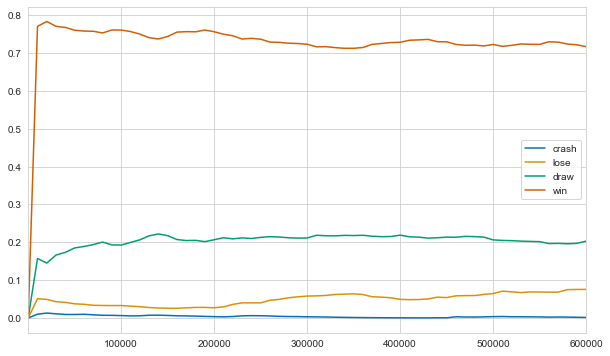

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(log_time, log_crash, 
        label="crash", color="C0")

ax.plot(log_time, log_lose, 
        label="lose", color="C1")

ax.plot(log_time, log_draw, 
        label="draw", color="C2")

ax.plot(log_time, log_win, 
        label="win", color="C3")


ax.legend(loc="center right")
ax.set_xlim((1, max(log_time)+1))
#ax.set_ylim((-2, 4))

Сеть быстро обучается, но не доидеального состояния. 

In [ ]:
сохраняем

In [125]:
with open( "data\hw_2_task_net_3_3.pkl", "wb" ) as f:
    pickle.dump( net_model, f )
with open( "data\hw_2_task_net_3_3_log.pkl", "wb" ) as f:
    pickle.dump( (log_time, log_crash, log_lose, log_draw, log_win, log_rewards), f )

In [ ]:
with open( "data\hw_2_task_net_3_3.pkl", "rb" ) as f:
    td_runner = pickle.load(f)
with open( "data\hw_2_task_net_3_3_log.pkl", "rb" ) as f:    
    log_time, log_crash, log_lose, log_draw, log_win, log_rewards = pickle.load( f )

## 4 на 4 DQN

Для полей большего размера использум более глубоку нейронную сеть

In [33]:
nnet_for_model = Conv3LayersModel_v7(num_rows = env.n_rows, num_col = env.n_cols)

In [473]:
nnet_for_model

Conv3LayersModel_v7(
  (block_up1): ResidualBlockUp(
    (conv_up): Conv2d(5, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block1): ResidualBlock(
    (conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_down): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (block2): ResidualBlock(
    (conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_down): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (block3): ResidualBlock(
    (conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

In [176]:
for l in nnet_for_model.parameters():
    print(l.shape, np.prod(l.shape))

torch.Size([40, 5, 3, 3]) 1800
torch.Size([40]) 40
torch.Size([40, 40, 3, 3]) 14400
torch.Size([40]) 40
torch.Size([40]) 40
torch.Size([40, 40, 3, 3]) 14400
torch.Size([40]) 40
torch.Size([40]) 40
torch.Size([40, 40, 3, 3]) 14400
torch.Size([40]) 40
torch.Size([40]) 40
torch.Size([40, 40, 3, 3]) 14400
torch.Size([40]) 40
torch.Size([40]) 40
torch.Size([40, 40, 3, 3]) 14400
torch.Size([40]) 40
torch.Size([40]) 40
torch.Size([5, 40, 3, 3]) 1800
torch.Size([5]) 5
torch.Size([1, 5, 1, 1]) 5
torch.Size([1]) 1


In [210]:
# game const
n_rows = 4
n_cols = 4
n_win  = 4

env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)

In [346]:
       
TRAIN_SIZE  = 0.8

nnet_for_model = Conv3LayersModel_v6(num_rows = env.n_rows, num_col = env.n_cols)
nnet_for_model.apply(init_weights)


net_model = Deep_net_learning_runner_v2(env, nnet_for_model, copy.deepcopy(nnet_for_model), 
                                     total_episodes = 10, 
                                     eps_value = 0.1, eps_value2 = 0.8, 
                                     alpha_mean = 0.001, alpha_Q = 0.1,
                 off_policy = True, memory_size = 500000)
        

In [ ]:
# Тестовый запуск
net_model.run(total_episodes = 3, eps_value = 0.5, eps_value2 = 0.8, verbose = True)

In [348]:
log_time = [0]
log_crash = [1]
log_lose = [0]
log_draw = [0]
log_win = [0]
log_rewards = [0]

In [ ]:
# Процесс обучения, запускаем несколько раз с разными параметрами
num_iterations = 150
learning_rate = 0.001
batch_size = 5000
num_epochs = 5

step_episodes = 200000
test_episodes = 200000

learning_rate = 0.000001
learning_rate = 0.0000005
batch_size = 20000

step_episodes = 20000
test_episodes = 1000
alpha = 0.3

learning_rate = 0.00005
batch_size = 5000
step_episodes = 3000
memory_size = 500000
num_repeat = 3 
add_repeat = 5


#learning_rate = 0.00001
#batch_size = 500
#learning_rate = 0.00001
#num_repeat = 2 # 4 до 120000
#batch_size = 500 # 200 до 120000

#learning_rate = 0.000001
#memory_size = 150000
#batch_size = 2000
#step_episodes = 5000
#num_repeat = 10

device = torch.device("cuda: 0") if False else torch.device("cpu")

loss_fn = nn.SmoothL1Loss(reduction="mean") #fnn.mse_loss
last_val_loss = 0
for i in trange(num_iterations):
    #new_net = TwoLayersModel()
    
    
    new_net = copy.deepcopy(net_model.nnet1)
    
    net_model.mean_rewards_log = []
    #net_model.history_buffer = []
    net_model.history_buffer.clear_old()
    
    print('buffer pos {:}, full: {:}'.format(net_model.history_buffer.position, net_model.history_buffer.full))

    values, counts = np.unique(net_model.history_buffer.n_priority.copy(), return_counts=True)
    pair = zip(values, counts)
    print(sorted(pair, key=lambda x: x[0])) 
    
    st = net_model.run(total_episodes = step_episodes, eps_value = 0.50, eps_value2 = 1.0, memory_size = memory_size, verbose = False)

    optimizer = optim.Adam(new_net.parameters(), lr=learning_rate, amsgrad=True)
    #optimizer = optim.SGD(new_net.parameters(), lr=learning_rate, momentum=0.9)AdamW

    dataset = HistoryPriorityDataset_v2(net_model.history_buffer, net_model.num_rows, net_model.num_cols, 
                                        num_repeat = num_repeat, add_repeat = add_repeat)
    dataset.sef_priority(new_net)
    
    train_dataset = dataset.get_subset(split="train")
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, pin_memory=True,
                                       shuffle=False, drop_last=True)

    val_dataset = dataset.get_subset(split="val")
    val_loader = data.DataLoader(val_dataset, batch_size = batch_size, num_workers=0, pin_memory=True,
                                     shuffle=False, drop_last=False)
    
    
    for epoch in range(num_epochs):
        train_loss = train(new_net, train_loader, loss_fn, optimizer, device=device, clip = 0.001)
        val_loss = validate(new_net, val_loader, loss_fn, device=device)

        print("epoch {:}, train_loss: {:2.5f}, val_loss: {:2.5f}, dval: {:2.7f}".format(epoch, train_loss, val_loss, last_val_loss - val_loss))
        

        if val_loss > last_val_loss and epoch > 0:
            #learning_rate = learning_rate / (1.01 ** (num_epochs - epoch - 1))
            #print('learning_rate: {:10.10f}'.format(learning_rate))
            break
        last_val_loss = val_loss
        
        #env.reset()
        #net_model.eps_value = 0.1
        #observation, reward, done, info = env.step(net_model.get_action_by_id(7))
        #x = net_model.get_state_tensor(env.board, -1)  
        #with torch.no_grad():
        #    pr = new_net(x).reshape(-1).detach().numpy().reshape(4, 4)
        
        #print('epoch: {:}, pr_0_0: {:6.4f}, pr_0_1: {:6.4f}, pr_0_2: {:6.4f}, pr_0_3: {:6.4f}, pr_1_2: {:6.4f}'.
        #  format(epoch, pr[0, 0], pr[0, 1], pr[0, 2], pr[0, 3], pr[1, 2]))        
            
    net_model.nnet1 = new_net
    
    
    #expect = monto_carlo_nnet_expectation(env, new_net, test_episodes)
    #expectation_logs.append(expect)
    #print("step {:}, expectation {:2.4f}".format(i, expectation_logs[-1][0]))
    al = max(1/(len(log_crash)), alpha)
    
    st = net_model.run(total_episodes = test_episodes, eps_value = 0.00, eps_value2 = 1.00, verbose = False)
    log_time.append(log_time[-1] + step_episodes)
    log_crash.append( (1 - al) * log_crash[-1] + al * st[-10] / test_episodes)
    log_lose.append( (1 - al) * log_lose[-1] + al * st[-1] / test_episodes)
    log_draw.append( (1 - al) * log_draw[-1] + al * st[0] / test_episodes)
    log_win.append( (1 - al) * log_win[-1] + al * st[1] / test_episodes)
    log_rewards.append( (1 - al) * log_rewards[-1] + al * np.mean(net_model.mean_rewards_log)) 
    
    env.reset()
    observation, reward, done, info = env.step(net_model.get_action_by_id(5))
    observation, reward, done, info = env.step(net_model.get_action_by_id(2))
    observation, reward, done, info = env.step(net_model.get_action_by_id(9))
    observation, reward, done, info = env.step(net_model.get_action_by_id(1))
    observation, reward, done, info = env.step(net_model.get_action_by_id(7))
    observation, reward, done, info = env.step(net_model.get_action_by_id(13))
    observation, reward, done, info = env.step(net_model.get_action_by_id(3))
    observation, reward, done, info = env.step(net_model.get_action_by_id(15))
    observation, reward, done, info = env.step(net_model.get_action_by_id(4))
    observation, reward, done, info = env.step(net_model.get_action_by_id(6))
    observation, reward, done, info = env.step(net_model.get_action_by_id(10))
    observation, reward, done, info = env.step(net_model.get_action_by_id(11))
    observation, reward, done, info = env.step(net_model.get_action_by_id(14))
    observation, reward, done, info = env.step(net_model.get_action_by_id(0))
    observation, reward, done, info = env.step(net_model.get_action_by_id(12))  
    x = net_model.get_state_tensor(env.board, -1)          
    pr = net_model.nnet1(x).reshape(-1).detach().numpy().reshape(4, 4)
    
    #print(np.mean(net_model.mean_rewards_log[-1000:]))
    #print('Шаг: {:}, падений: {:}, поражений: {:}, ничьих: {:}, побед: {:}'.format(i, st[-10], st[-1], st[0], st[1]))
    print('Шаг:{:}, падений: {:}({:},{:}), поражений: {:}({:},{:}), ничьих: {:}({:},{:}), побед: {:}({:},{:}) good: {:}, b: {:5.4f}, g: {:5.4f}'.
          format(i, st[-10], st['f_-10'], st['s_-10'], st[-1], st['f_-1'], st['s_-1'], st[0], st['f_0'], st['s_0'],  
                 st[1], st['f_1'], st['s_1'],
                 np.sum(np.array(net_model.history_buffer.n_priority) >= 0), pr[0, 3], pr[2, 0]))
    net_model.nnet2 = copy.deepcopy(net_model.nnet1)  

In [375]:
# Игра со случайной стратегией
st = net_model.run(total_episodes = 10000, eps_value = 0.00, eps_value2 = 1.00, verbose = False)    
print('Шаг:{:}, падений: {:}({:},{:}), поражений: {:}({:},{:}), ничьих: {:}({:},{:}), побед: {:}({:},{:})'.
      format(i, st[-10], st['f_-10'], st['s_-10'], st[-1], st['f_-1'], st['s_-1'], st[0], st['f_0'], st['s_0'],  
             st[1], st['f_1'], st['s_1']))

Шаг:104, падений: 9(0,9), поражений: 97(76,21), ничьих: 2832(189,2643), побед: 7062(4774,2288)


In [376]:
# Игра с самим собой стратегией
st = net_model.run(total_episodes = 1000, eps_value = 0.00, eps_value2 = 0.00, verbose = False)    
print('Шаг:{:}, падений: {:}({:},{:}), поражений: {:}({:},{:}), ничьих: {:}({:},{:}), побед: {:}({:},{:})'.
      format(i, st[-10], st['f_-10'], st['s_-10'], st[-1], st['f_-1'], st['s_-1'], st[0], st['f_0'], st['s_0'],  
             st[1], st['f_1'], st['s_1']))

Шаг:104, падений: 0(0,0), поражений: 0(0,0), ничьих: 502(0,502), побед: 498(498,0)


(1.0, 509001.0)

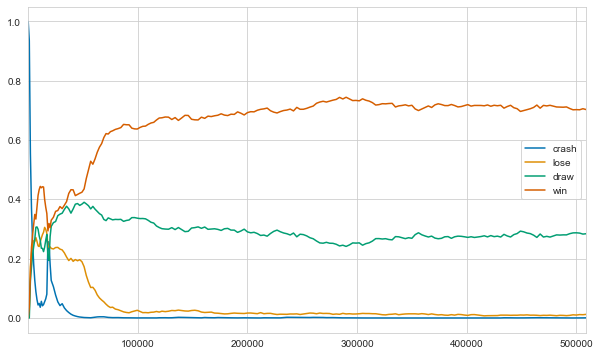

In [368]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(log_time, log_crash, 
        label="crash", color="C0")

ax.plot(log_time, log_lose, 
        label="lose", color="C1")

ax.plot(log_time, log_draw, 
        label="draw", color="C2")

ax.plot(log_time, log_win, 
        label="win", color="C3")


ax.legend(loc="center right")
ax.set_xlim((1, max(log_time)+1))
#ax.set_ylim((-2, 4))

(0.0, 0.1)

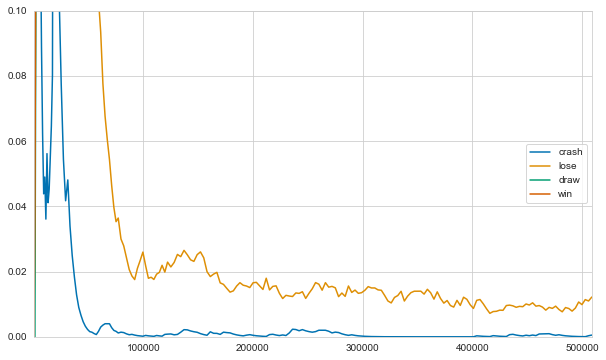

In [369]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(log_time, log_crash, 
        label="crash", color="C0")

ax.plot(log_time, log_lose, 
        label="lose", color="C1")

ax.plot(log_time, log_draw, 
        label="draw", color="C2")

ax.plot(log_time, log_win, 
        label="win", color="C3")


ax.legend(loc="center right")
ax.set_xlim((1, max(log_time)+1))
ax.set_ylim((0, 0.1))

Модель обучилась играть довольно качественно

In [ ]:
сохраняем

In [371]:
# cеть v6
with open( "data\hw_2_task_net_4_4_3_v6.pkl", "wb" ) as f:
    pickle.dump( net_model, f )
with open( "data\hw_2_task_net_4_4_3_v6_log.pkl", "wb" ) as f:
    pickle.dump( (log_time, log_crash, log_lose, log_draw, log_win, log_rewards), f )

## 5 на 5 DQN

Обучим сеть играть на поле 5 на 5

In [34]:
# game const
n_rows = 5
n_cols = 5
n_win  = 5

env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)

In [35]:
    
TRAIN_SIZE  = 0.8

nnet_for_model = Conv3LayersModel_v6(num_rows = env.n_rows, num_col = env.n_cols)
nnet_for_model.apply(init_weights)


net_model = Deep_net_learning_runner_v2(env, nnet_for_model, copy.deepcopy(nnet_for_model), 
                                     eps_value = 0.1, eps_value2 = 0.8, off_policy = True, memory_size = 500000)

In [39]:
net_model = Deep_net_learning_runner_v2(env, nnet_for_model, copy.deepcopy(nnet_for_model), 
                                     eps_value = 0.1, eps_value2 = 0.8, off_policy = True, memory_size = 500000)

In [ ]:
# Тестовый запуск
net_model.run(total_episodes = 3, eps_value = 0.5, eps_value2 = 0.8, verbose = True)

In [40]:
log_time = [0]
log_crash = [1]
log_lose = [0]
log_draw = [0]
log_win = [0]
log_rewards = [0]

In [ ]:
#
num_iterations = 30
num_epochs = 4
test_episodes = 500
alpha = 0.3

learning_rate = 0.0001
batch_size = 100
step_episodes = 1000
memory_size = 200000
num_repeat = 2 # Если > 0 то сложные примеры будет дольше в буфере
add_repeat = 5 # Время жизни примера

learning_rate = 0.00005
batch_size = 2500
step_episodes = 1000
memory_size = 500000

learning_rate = 0.0001
batch_size = 100 # 10

learning_rate = 0.00005
batch_size = 500 # 10

learning_rate = 0.00005
batch_size = 5000 # 10

learning_rate = 0.00005
step_episodes = 1500
batch_size = 10000 # 10



device = torch.device("cuda: 0") if False else torch.device("cpu")

loss_fn = nn.SmoothL1Loss(reduction="mean") #fnn.mse_loss
last_val_loss = 0
for i in trange(num_iterations):
    new_net = copy.deepcopy(net_model.nnet1)
    
    net_model.mean_rewards_log = []
    net_model.history_buffer.clear_old()
    
    # print('buffer pos {:}, full: {:}'.format(net_model.history_buffer.position, net_model.history_buffer.full))
  
    st = net_model.run(total_episodes = step_episodes, eps_value = 0.10, eps_value2 = 0.8, 
                       soft_exploration = True, delta_eps = 0.2,
                       memory_size = memory_size, verbose = False)

    optimizer = optim.Adam(new_net.parameters(), lr=learning_rate, amsgrad=True)
    #optimizer = optim.SGD(new_net.parameters(), lr=learning_rate, momentum=0.9)AdamW

    dataset = HistoryPriorityDataset_v2(net_model.history_buffer, net_model.num_rows, net_model.num_cols, 
                                        num_repeat = num_repeat, add_repeat = add_repeat)
    dataset.sef_priority(new_net)
    
    train_dataset = dataset.get_subset(split="train")
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, pin_memory=True,
                                       shuffle=False, drop_last=True)

    val_dataset = dataset.get_subset(split="val")
    val_loader = data.DataLoader(val_dataset, batch_size = batch_size, num_workers=0, pin_memory=True,
                                     shuffle=False, drop_last=False)
       
    for epoch in range(num_epochs):
        train_loss = train(new_net, train_loader, loss_fn, optimizer, device=device, clip = 0.001)
        val_loss = validate(new_net, val_loader, loss_fn, device=device)

        print("epoch {:}, train_loss: {:2.5f}, val_loss: {:2.5f}, dval: {:2.7f}".format(epoch, train_loss, val_loss, last_val_loss - val_loss))
        
        if val_loss > last_val_loss and epoch > 0:
            break
            
        last_val_loss = val_loss     
            
    net_model.nnet1 = new_net
    
    
    #expect = monto_carlo_nnet_expectation(env, new_net, test_episodes)
    #expectation_logs.append(expect)
    #print("step {:}, expectation {:2.4f}".format(i, expectation_logs[-1][0]))
    al = max(1/(len(log_crash)), alpha)
    
    st = net_model.run(total_episodes = test_episodes, eps_value = 0.00, eps_value2 = 1.00, soft_exploration = False, verbose = False)
    log_time.append(log_time[-1] + step_episodes)
    log_crash.append( (1 - al) * log_crash[-1] + al * st[-10] / test_episodes)
    log_lose.append( (1 - al) * log_lose[-1] + al * st[-1] / test_episodes)
    log_draw.append( (1 - al) * log_draw[-1] + al * st[0] / test_episodes)
    log_win.append( (1 - al) * log_win[-1] + al * st[1] / test_episodes)
    log_rewards.append( (1 - al) * log_rewards[-1] + al * np.mean(net_model.mean_rewards_log)) 
    
    #print(np.mean(net_model.mean_rewards_log[-1000:]))
    #print('Шаг: {:}, падений: {:}, поражений: {:}, ничьих: {:}, побед: {:}'.format(i, st[-10], st[-1], st[0], st[1]))
    print('Шаг:{:}, падений: {:}({:},{:}), поражений: {:}({:},{:}), ничьих: {:}({:},{:}), побед: {:}({:},{:}), score= {:}({:},{:}) buffer: {:}'.
          format(i, st[-10], st['f_-10'], st['s_-10'], st[-1], st['f_-1'], st['s_-1'], st[0], st['f_0'], st['s_0'],  
                 st[1], st['f_1'], st['s_1'] , -st[-1]+st[1], -st['f_-1']+st['f_1'], -st['s_-1']+st['s_1'],
                 np.sum(np.array(net_model.history_buffer.n_priority) >= 0) + np.sum(np.array(net_model.history_buffer.n_priority) == -2000)))
    net_model.nnet2 = copy.deepcopy(net_model.nnet1)  

(1.0, 270501.0)

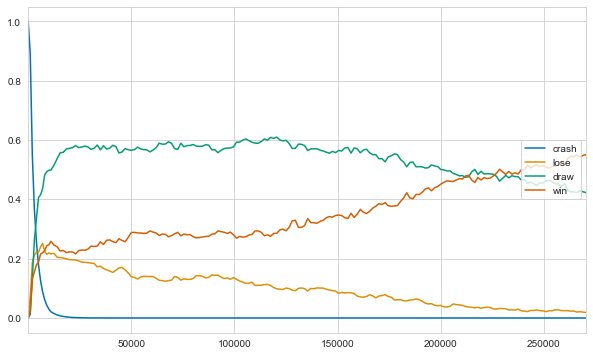

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(log_time, log_crash, 
        label="crash", color="C0")

ax.plot(log_time, log_lose, 
        label="lose", color="C1")

ax.plot(log_time, log_draw, 
        label="draw", color="C2")

ax.plot(log_time, log_win, 
        label="win", color="C3")


ax.legend(loc="center right")
ax.set_xlim((1, max(log_time)+1))
#ax.set_ylim((-2, 4))

In [87]:
# Игра со случайной стратегией
st = net_model.run(total_episodes = 10000, eps_value = 0.00, eps_value2 = 1.00, soft_exploration = False, verbose = False)    
print('Шаг:{:}, падений: {:}({:},{:}), поражений: {:}({:},{:}), ничьих: {:}({:},{:}), побед: {:}({:},{:})'.
      format(i, st[-10], st['f_-10'], st['s_-10'], st[-1], st['f_-1'], st['s_-1'], st[0], st['f_0'], st['s_0'],  
             st[1], st['f_1'], -st[-1]+st[1], -st['f_-1']+st['f_1'], -st['s_-1']+st['s_1']))

Шаг:7, падений: 0(0,0), поражений: 1244(348,896), ничьих: 2839(783,2056), побед: 5865(3867,1998)


In [239]:
# Игра с самим собой стратегией
st = net_model.run(total_episodes = 1000, eps_value = 0.00, eps_value2 = 0.00, soft_exploration = True, delta_eps = 0.01, verbose = False)    
print('Шаг:{:}, падений: {:}({:},{:}), поражений: {:}({:},{:}), ничьих: {:}({:},{:}), побед: {:}({:},{:})'.
      format(i, st[-10], st['f_-10'], st['s_-10'], st[-1], st['f_-1'], st['s_-1'], st[0], st['f_0'], st['s_0'],  
             st[1], st['f_1'], st['s_1']))

Шаг:4, падений: 0(0,0), поражений: 223(165,58), ничьих: 521(110,411), побед: 256(215,41)


Модель хорошо учиться, хотя и не быстро (данный результат после 10 часов)

Сохраняем результат

In [89]:
# cеть v6
with open( "data\hw_2_task_net_5_5_3_v6.pkl", "wb" ) as f:
    pickle.dump( net_model, f )
with open( "data\hw_2_task_net_5_5_3_v6_log.pkl", "wb" ) as f:
    pickle.dump( (log_time, log_crash, log_lose, log_draw, log_win, log_rewards), f )

In [231]:
with open( "data\hw_2_task_net_5_5_3_v6.pkl", "rb" ) as f:
    net_model = pickle.load(f)
with open( "data\hw_2_task_net_5_5_3_v6_log.pkl", "rb" ) as f:    
    log_time, log_crash, log_lose, log_draw, log_win, log_rewards = pickle.load( f )

In [49]:
# cеть v6 + soft
with open( "data\hw_2_task_net_5_5_soft_v6.pkl", "wb" ) as f:
    pickle.dump( net_model, f )
with open( "data\hw_2_task_net_5_5_soft_v6_log.pkl", "wb" ) as f:
    pickle.dump( (log_time, log_crash, log_lose, log_draw, log_win, log_rewards), f )

## Double DQN

Реализуйте Double DQN и/или Dueling DQN.

In [29]:
n_rows = 5
n_cols = 5
n_win  = 5

env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)

In [52]:
nnet_for_model1 = Conv3LayersModel_v6(num_rows = env.n_rows, num_col = env.n_cols)
nnet_for_model1.apply(init_weights)

nnet_for_model2 = Conv3LayersModel_v6(num_rows = env.n_rows, num_col = env.n_cols)
nnet_for_model2.apply(init_weights)

# Для обучения первой модели
dual_model1 = Deep_net_learning_runner_v2(env, nnet_for_model1, nnet_for_model2, 
                                     eps_value = 0.1, eps_value2 = 0.8, off_policy = True, memory_size = 500000)

# Для обучения второй модели
dual_model2 = Deep_net_learning_runner_v2(env, nnet_for_model2, nnet_for_model1, 
                                     eps_value = 0.1, eps_value2 = 0.8, off_policy = True, memory_size = 500000)        

In [53]:
# 
log_time1 = [0]
log_crash1 = [1]
log_lose1 = [0]
log_draw1 = [0]
log_win1 = [0]
log_time2 = [0]
log_crash2 = [1]
log_lose2 = [0]
log_draw2 = [0]
log_win2 = [0]

Обучаем параллельно две стратегии, и используем их для оценки максимума при обучении нейросетей

In [ ]:
#
num_iterations = 20
num_epochs = 4
test_episodes = 500
alpha = 0.2

num_repeat = 1 # Если > 0 то сложные примеры будет дольше в буфере
add_repeat = 5 # Время жизни примера
memory_size = 500000

learning_rate = 0.00005
batch_size = 2500
step_episodes = 1000

learning_rate = 0.0001
batch_size = 100 # 10

learning_rate = 0.00005
batch_size = 500 # 10

learning_rate = 0.00005
batch_size = 5000 # 10

learning_rate = 0.00005
batch_size = 5000 # 10
step_episodes = 2000

learning_rate = 0.0001
batch_size = 100
step_episodes = 1000

learning_rate = 0.00005
batch_size = 500

batch_size = 5000
eps = 0.8
step_episodes = 1500
add_repeat = 6

device = torch.device("cuda: 0") if False else torch.device("cpu")

loss_fn = nn.SmoothL1Loss(reduction="mean") #fnn.mse_loss
last_val_loss = 0
for i in trange(num_iterations):

    # Учим первую модель
    new_net = copy.deepcopy(dual_model1.nnet1)
    
    dual_model1.mean_rewards_log = []
    dual_model1.history_buffer.clear_old()
    
    st = dual_model1.run(total_episodes = step_episodes, eps_value = 0.1, eps_value2 = eps, 
                         soft_exploration = True, delta_eps = 0.3, memory_size = memory_size, verbose = False)

    optimizer = optim.Adam(new_net.parameters(), lr=learning_rate, amsgrad=True)

    dataset = HistoryPriorityDataset_v2(dual_model1.history_buffer, dual_model1.num_rows, dual_model1.num_cols, 
                                        num_repeat = num_repeat, add_repeat = add_repeat)
    dataset.sef_priority(new_net)
    
    train_dataset = dataset.get_subset(split="train")
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, pin_memory=True,
                                       shuffle=False, drop_last=True)

    val_dataset = dataset.get_subset(split="val")
    val_loader = data.DataLoader(val_dataset, batch_size = batch_size, num_workers=0, pin_memory=True,
                                     shuffle=False, drop_last=False)
    
    
    for epoch in range(num_epochs):
        train_loss = train(new_net, train_loader, loss_fn, optimizer, device=device, clip = 0.001)
        val_loss = validate(new_net, val_loader, loss_fn, device=device)

        print("Model 1 epoch {:}, train_loss: {:2.5f}, val_loss: {:2.5f}, dval: {:2.7f}".format(epoch, train_loss, val_loss, last_val_loss - val_loss))

        if val_loss > last_val_loss and epoch > 0:
            break
        last_val_loss = val_loss
 
    dual_model1.nnet1 = new_net
    
    # Учим вторую модель
    new_net = copy.deepcopy(dual_model2.nnet1)
    
    dual_model2.mean_rewards_log = []
    dual_model2.history_buffer.clear_old()
    
    st = dual_model2.run(total_episodes = step_episodes, eps_value = 0.1, eps_value2 = eps, 
                         soft_exploration = True, delta_eps = 0.3, memory_size = memory_size, verbose = False)

    optimizer = optim.Adam(new_net.parameters(), lr=learning_rate, amsgrad=True)
    #optimizer = optim.SGD(new_net.parameters(), lr=learning_rate, momentum=0.9)AdamW

    dataset = HistoryPriorityDataset_v2(dual_model2.history_buffer, dual_model2.num_rows, dual_model2.num_cols, 
                                        num_repeat = num_repeat, add_repeat = add_repeat)
    dataset.sef_priority(new_net)
    
    train_dataset = dataset.get_subset(split="train")
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, pin_memory=True,
                                       shuffle=False, drop_last=True)

    val_dataset = dataset.get_subset(split="val")
    val_loader = data.DataLoader(val_dataset, batch_size = batch_size, num_workers=0, pin_memory=True,
                                     shuffle=False, drop_last=False)
    
    for epoch in range(num_epochs):
        train_loss = train(new_net, train_loader, loss_fn, optimizer, device=device, clip = 0.001)
        val_loss = validate(new_net, val_loader, loss_fn, device=device)

        print("Model 2 epoch {:}, train_loss: {:2.5f}, val_loss: {:2.5f}, dval: {:2.7f}".format(epoch, train_loss, val_loss, last_val_loss - val_loss))

        if val_loss > last_val_loss and epoch > 0:
            break
        last_val_loss = val_loss         
 
    dual_model2.nnet1 = new_net    
    
    # Изменяем модели для оценки
    dual_model1.nnet_max1 = copy.deepcopy(dual_model2.nnet1)
    dual_model2.nnet_max1 = copy.deepcopy(dual_model1.nnet1)
    
    # Оценка качества
    al = max(1/(len(log_crash1)), alpha)
    
    st1 = dual_model1.run(total_episodes = test_episodes, alpha_mean = 0.001, eps_value = 0.00, eps_value2 = 1.00, verbose = False)
    log_time1.append(log_time1[-1] + step_episodes)
    log_crash1.append( (1 - al) * log_crash1[-1] + al * st1[-10] / test_episodes)
    log_lose1.append( (1 - al) * log_lose1[-1] + al * st1[-1] / test_episodes)
    log_draw1.append( (1 - al) * log_draw1[-1] + al * st1[0] / test_episodes)
    log_win1.append( (1 - al) * log_win1[-1] + al * st1[1] / test_episodes)

    st2 = dual_model2.run(total_episodes = test_episodes, alpha_mean = 0.001, eps_value = 0.00, eps_value2 = 1.00, verbose = False)
    log_time2.append(log_time2[-1] + step_episodes)
    log_crash2.append( (1 - al) * log_crash2[-1] + al * st2[-10] / test_episodes)
    log_lose2.append( (1 - al) * log_lose2[-1] + al * st2[-1] / test_episodes)
    log_draw2.append( (1 - al) * log_draw2[-1] + al * st2[0] / test_episodes)
    log_win2.append( (1 - al) * log_win2[-1] + al * st2[1] / test_episodes)
 
    print('In buffer 1: {:}  2: {:}'.format(np.sum(np.array(dual_model1.history_buffer.n_priority) >= 0) + 
                 np.sum(np.array(dual_model1.history_buffer.n_priority) == -2000),
                 np.sum(np.array(dual_model2.history_buffer.n_priority) >= 0) + 
                 np.sum(np.array(dual_model2.history_buffer.n_priority) == -2000)))
    print('Шаг:{:}, 1: падений: {:}({:},{:}), поражений: {:}({:},{:}), ничьих: {:}({:},{:}), побед: {:}({:},{:}) score = {:}({:},{:})'.
          format(i, st1[-10], st1['f_-10'], st1['s_-10'], st1[-1], st1['f_-1'], st1['s_-1'], st1[0], st1['f_0'], st1['s_0'],  
                 st1[1], st1['f_1'], st1['s_1'], -st1[-1]+st1[1], -st1['f_-1']+st1['f_1'], -st1['s_-1']+st1['s_1']))

    print('Шаг:{:}, 2: падений: {:}({:},{:}), поражений: {:}({:},{:}), ничьих: {:}({:},{:}), побед: {:}({:},{:}) score = {:}({:},{:})'.
          format(i, st2[-10], st2['f_-10'], st2['s_-10'], st2[-1], st2['f_-1'], st2['s_-1'], st2[0], st2['f_0'], st2['s_0'],  
                 st2[1], st2['f_1'], st2['s_1'], -st2[-1]+st2[1], -st2['f_-1']+st2['f_1'], -st2['s_-1']+st2['s_1']))
        
    # print('Шаг: {:}, 1: падений: {:}, поражений: {:}, ничьих: {:}, побед: {:} 2: падений: {:}, поражений: {:}, ничьих: {:}, побед: {:}'.
    #      format(i, st1[-10], st1[-1], st1[0], st1[1], st2[-10], st2[-1], st2[0], st2[1]))
    
    # Обновляем модели второго игрока
    dual_model1.nnet2 = copy.deepcopy(dual_model1.nnet1)  
    dual_model2.nnet2 = copy.deepcopy(dual_model2.nnet1) 

(1.0, 128001.0)

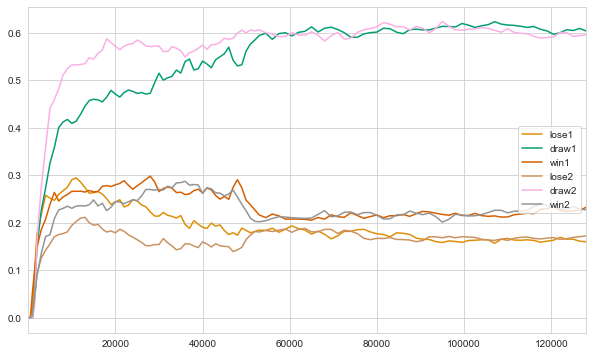

In [69]:
#
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

#ax.plot(log_time1, log_crash1, label="crash1", color="C0")
ax.plot(log_time1, log_lose1, label="lose1", color="C1")
ax.plot(log_time1, log_draw1,  label="draw1", color="C2")
ax.plot(log_time1, log_win1,  label="win1", color="C3")

#ax.plot(log_time2, log_crash2, label="crash2", color="C4")
ax.plot(log_time2, log_lose2, label="lose2", color="C5")
ax.plot(log_time2, log_draw2, label="draw2", color="C6")
ax.plot(log_time2, log_win2, label="win2", color="C7")

ax.legend(loc="center right")
ax.set_xlim((1, max(log_time1)+1))

Сеть обучается, но результат не лучше, чем у одиночной сети

In [71]:
# Сохраняем
# cеть v6
with open( "data\hw_2_task_net_5_5_Double_v6.pkl", "wb" ) as f:
    pickle.dump( (dual_model1, dual_model2) , f )
with open( "data\hw_2_task_net_5_5_Double_v6_log.pkl", "wb" ) as f:
    pickle.dump( (log_time1, log_crash1, log_lose1, log_draw1, log_win1, 
                  log_time2, log_crash2, log_lose2, log_draw2, log_win2), f )

## 5 на 5 DQN более глубокая сеть

In [13]:
# game const
n_rows = 5
n_cols = 5
n_win  = 5

env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.005)
        
TRAIN_SIZE  = 0.8

nnet_for_model = Conv3LayersModel_v7(num_rows = env.n_rows, num_col = env.n_cols)
nnet_for_model.apply(init_weights)

net_model = Deep_net_learning_runner_v2(env, nnet_for_model, copy.deepcopy(nnet_for_model), 
                                     eps_value = 0.1, eps_value2 = 0.8, off_policy = True, memory_size = 500000)

In [475]:
# Структура нейронной сети
nnet_for_model

Conv3LayersModel_v7(
  (block_up1): ResidualBlockUp(
    (conv_up): Conv2d(5, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block1): ResidualBlock(
    (conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_down): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (block2): ResidualBlock(
    (conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_down): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (block3): ResidualBlock(
    (conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

In [ ]:
# Тестовый запуск
net_model.run(total_episodes = 3, eps_value = 0.5, eps_value2 = 0.8, verbose = True)

In [477]:
log_time = [0]
log_crash = [1]
log_lose = [0]
log_draw = [0]
log_win = [0]
log_rewards = [0]

In [159]:
# Обучение
num_iterations = 1
num_epochs = 4
test_episodes = 500
alpha = 0.3

learning_rate = 0.0001
batch_size = 100
step_episodes = 1000
memory_size = 500000
num_repeat = 2 # Если > 0 то сложные примеры будет дольше в буфере
add_repeat = 5 # Время жизни примера

eps = 1.0
learning_rate = 0.00005
batch_size = 2500
step_episodes = 1000
memory_size = 500000

learning_rate = 0.0001
batch_size = 100 # 10

learning_rate = 0.00005
batch_size = 500 # 10

learning_rate = 0.00005
batch_size = 5000 # 10

learning_rate = 0.00005
step_episodes = 1500
batch_size = 10000 # 10

learning_rate = 0.00005
step_episodes = 1500
batch_size = 30000 # 10

learning_rate = 0.00002
eps = 0.8

device = torch.device("cuda: 0") if False else torch.device("cpu")

loss_fn = nn.SmoothL1Loss(reduction="mean") #fnn.mse_loss
last_val_loss = 0
for i in trange(num_iterations):
    new_net = copy.deepcopy(net_model.nnet1)
    
    net_model.mean_rewards_log = []
    net_model.history_buffer.clear_old()
    
    # print('buffer pos {:}, full: {:}'.format(net_model.history_buffer.position, net_model.history_buffer.full))
  
    st = net_model.run(total_episodes = step_episodes, eps_value = 0.10, eps_value2 = eps, 
                       soft_exploration = True, delta_eps = 0.2,
                       memory_size = memory_size, verbose = False)

    optimizer = optim.Adam(new_net.parameters(), lr=learning_rate, amsgrad=True)
    #optimizer = optim.SGD(new_net.parameters(), lr=learning_rate, momentum=0.9)AdamW

    dataset = HistoryPriorityDataset_v2(net_model.history_buffer, net_model.num_rows, net_model.num_cols, 
                                        num_repeat = num_repeat, add_repeat = add_repeat)
    dataset.sef_priority(new_net)
    
    train_dataset = dataset.get_subset(split="train")
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, pin_memory=True,
                                       shuffle=False, drop_last=True)

    val_dataset = dataset.get_subset(split="val")
    val_loader = data.DataLoader(val_dataset, batch_size = batch_size, num_workers=0, pin_memory=True,
                                     shuffle=False, drop_last=False)
       
    for epoch in range(num_epochs):
        train_loss = train(new_net, train_loader, loss_fn, optimizer, device=device, clip = 0.001)
        val_loss = validate(new_net, val_loader, loss_fn, device=device)

        print("epoch {:}, train_loss: {:2.5f}, val_loss: {:2.5f}, dval: {:2.7f}".format(epoch, train_loss, val_loss, last_val_loss - val_loss))
        
        if val_loss > last_val_loss and epoch > 0:
            break
            
        last_val_loss = val_loss     
            
    net_model.nnet1 = new_net
    
    
    #expect = monto_carlo_nnet_expectation(env, new_net, test_episodes)
    #expectation_logs.append(expect)
    #print("step {:}, expectation {:2.4f}".format(i, expectation_logs[-1][0]))
    al = max(1/(len(log_crash)), alpha)
    
    st = net_model.run(total_episodes = test_episodes, eps_value = 0.00, eps_value2 = 1.00, soft_exploration = False, verbose = False)
    log_time.append(log_time[-1] + step_episodes)
    log_crash.append( (1 - al) * log_crash[-1] + al * st[-10] / test_episodes)
    log_lose.append( (1 - al) * log_lose[-1] + al * st[-1] / test_episodes)
    log_draw.append( (1 - al) * log_draw[-1] + al * st[0] / test_episodes)
    log_win.append( (1 - al) * log_win[-1] + al * st[1] / test_episodes)
    log_rewards.append( (1 - al) * log_rewards[-1] + al * np.mean(net_model.mean_rewards_log)) 
    
    st = {key: int(1000 * v / test_episodes) for key, v in st.items()} # Приведем к 1000 запусков
    print('Шаг:{:}, падений: {:}({:},{:}), поражений: {:}({:},{:}), ничьих: {:}({:},{:}), побед: {:}({:},{:}), score: {:}({:},{:}) buffer: {:}'.
          format(i, st[-10], st['f_-10'], st['s_-10'], st[-1], st['f_-1'], st['s_-1'], st[0], st['f_0'], st['s_0'],  
                 st[1], st['f_1'], st['s_1'] , -st[-1]+st[1], -st['f_-1']+st['f_1'], -st['s_-1']+st['s_1'],
                 np.sum(np.array(net_model.history_buffer.n_priority) >= 0) + np.sum(np.array(net_model.history_buffer.n_priority) == -2000)))
    net_model.nnet2 = copy.deepcopy(net_model.nnet1)  

epoch 0, train_loss: 0.00131, val_loss: 0.00104, dval: -0.0010417
epoch 1, train_loss: 0.00131, val_loss: 0.00104, dval: 0.0000012
epoch 2, train_loss: 0.00130, val_loss: 0.00104, dval: 0.0000010
epoch 3, train_loss: 0.00130, val_loss: 0.00104, dval: 0.0000019
Шаг:0, падений: 0(0,0), поражений: 12(8,4), ничьих: 396(46,350), побед: 586(460,126), score: 574(452,122) buffer: 214324



(0.0, 0.65)

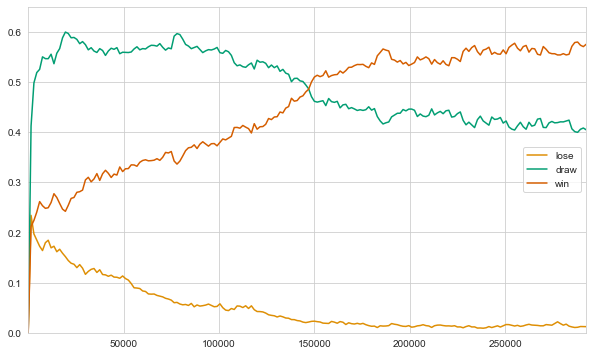

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(log_time, log_lose, 
        label="lose", color="C1")

ax.plot(log_time, log_draw, 
        label="draw", color="C2")

ax.plot(log_time, log_win, 
        label="win", color="C3")


ax.legend(loc="center right")
ax.set_xlim((1, max(log_time)+1))
ax.set_ylim((0, 0.65))

In [154]:
# Игра со случайной стратегией
st = net_model.run(total_episodes = 1000, eps_value = 0.00, eps_value2 = 1.00, soft_exploration = False, verbose = False)    

print("Всего игр: {:} из них побед: {:}, ничьих: {:}, поражений: {:}.".format(st[-1] + st[0] + st[1], st[1], st[0], st[-1]))
num_f = (st['f_-1'] + st['f_0'] + st['f_1']) / 100
print("За крестиков в % побед: {:3.1f}%, ничьих: {:3.1f}%, поражений: {:3.1f}%.".format(
    st['f_1'] / num_f, st['f_0'] / num_f, st['f_-1'] / num_f
))
num_s = (st['s_-1'] + st['s_0'] + st['s_1']) / 100
print("За ноликов в % побед: {:3.1f}%, ничьих: {:3.1f}%, поражений: {:3.1f}%.".format(
    st['s_1'] / num_s, st['s_0'] / num_s, st['s_-1'] / num_s
))

Всего игр: 996 из них побед: 568, ничьих: 410, поражений: 18.
За крестиков в % побед: 87.4%, ничьих: 10.4%, поражений: 2.3%.
За ноликов в % побед: 28.5%, ничьих: 70.2%, поражений: 1.4%.


In [155]:
# Игра с самим собой 
st = net_model.run(total_episodes = 1000, eps_value = 0.00, eps_value2 = 0.00, soft_exploration = True, delta_eps = 0.05, verbose = False)    

print("Всего игр: {:} из них побед: {:}, ничьих: {:}, поражений: {:}.".format(st[-1] + st[0] + st[1], st[1], st[0], st[-1]))
num_f = (st['f_-1'] + st['f_0'] + st['f_1']) / 100
print("За крестиков в % побед: {:3.1f}%, ничьих: {:3.1f}%, поражений: {:3.1f}%.".format(
    st['f_1'] / num_f, st['f_0'] / num_f, st['f_-1'] / num_f
))
num_s = (st['s_-1'] + st['s_0'] + st['s_1']) / 100
print("За ноликов в % побед: {:3.1f}%, ничьих: {:3.1f}%, поражений: {:3.1f}%.".format(
    st['s_1'] / num_s, st['s_0'] / num_s, st['s_-1'] / num_s
))

Всего игр: 1000 из них побед: 270, ничьих: 499, поражений: 231.
За крестиков в % побед: 49.5%, ничьих: 8.7%, поражений: 41.7%.
За ноликов в % побед: 3.1%, ничьих: 93.6%, поражений: 3.3%.


Сохраняем результат

In [ ]:
# cеть v7
with open( "data\hw_2_task_net_5_5_soft_v7.pkl", "wb" ) as f:
    pickle.dump( net_model, f )
with open( "data\hw_2_task_net_5_5_soft_v7_log.pkl", "wb" ) as f:
    pickle.dump( (log_time, log_crash, log_lose, log_draw, log_win, log_rewards), f )

In [ ]:
with open( "data\hw_2_task_net_5_5_soft_v7.pkl", "rb" ) as f:
    net_model = pickle.load(f)
with open( "data\hw_2_task_net_5_5_soft_v7_log.pkl", "rb" ) as f:
    log_time, log_crash, log_lose, log_draw, log_win, log_rewards = pickle.load(f)   

## 10 на 10 DQN 

Проверка на то как модель обобщается на большем поле

In [80]:
# game const
n_rows = 10
n_cols = 10
n_win  = 5

env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)

In [93]:
     
TRAIN_SIZE  = 0.8

nnet_for_model = Conv3LayersModel_v7(num_rows = env.n_rows, num_col = env.n_cols)
nnet_for_model.apply(init_weights)

net_model = Deep_net_learning_runner_v2(env, nnet_for_model, copy.deepcopy(nnet_for_model), 
                                     eps_value = 0.1, eps_value2 = 0.8, off_policy = True, memory_size = 500000)

In [85]:
# Структура нейронной сети
nnet_for_model

Conv3LayersModel_v7(
  (block_up1): ResidualBlockUp(
    (conv_up): Conv2d(5, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block1): ResidualBlock(
    (conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_down): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (block2): ResidualBlock(
    (conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_down): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (block3): ResidualBlock(
    (conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

In [ ]:
# Тестовый запуск
net_model.run(total_episodes = 3, eps_value = 0.5, eps_value2 = 0.8, verbose = True)

In [94]:
log_time = [0]
log_crash = [1]
log_lose = [0]
log_draw = [0]
log_win = [0]
log_rewards = [0]

In [107]:
time.process_time()

299110.484375

In [ ]:
#
num_iterations = 5
num_epochs = 4
test_episodes = 500
alpha = 0.3

learning_rate = 0.0001
batch_size = 100
step_episodes = 1000
memory_size = 500000
num_repeat = 1 # Если > 0 то сложные примеры будет дольше в буфере
add_repeat = 4 # Время жизни примера

learning_rate = 0.00005
batch_size = 2500
step_episodes = 1000
memory_size = 500000

learning_rate = 0.0001
batch_size = 100 # 10

learning_rate = 0.00005
batch_size = 500 # 10

learning_rate = 0.00005
batch_size = 5000 # 10

learning_rate = 0.00005
step_episodes = 1500
batch_size = 10000 # 10

learning_rate = 0.00005
step_episodes = 1000
batch_size = 5000 # 10

learning_rate = 0.0001
batch_size = 100 # 10

learning_rate = 0.00005
step_episodes = 1000
batch_size = 5000 # 10
add_repeat = 10
num_repeat = 2
memory_size = 1000000
test_episodes = 200

device = torch.device("cuda: 0") if False else torch.device("cpu")

loss_fn = nn.SmoothL1Loss(reduction="mean") #fnn.mse_loss
last_val_loss = 0
for i in trange(num_iterations):
    print('start', time.process_time())
    new_net = copy.deepcopy(net_model.nnet1)
    
    net_model.mean_rewards_log = []
    net_model.history_buffer.clear_old()
    
    # print('buffer pos {:}, full: {:}'.format(net_model.history_buffer.position, net_model.history_buffer.full))
  
    st = net_model.run(total_episodes = step_episodes, eps_value = 0.10, eps_value2 = 0.5, 
                       soft_exploration = True, delta_eps = 0.1,
                       memory_size = memory_size, verbose = False)
    print('collect', time.process_time())
    optimizer = optim.Adam(new_net.parameters(), lr=learning_rate, amsgrad=True)
    #optimizer = optim.SGD(new_net.parameters(), lr=learning_rate, momentum=0.9)AdamW

    dataset = HistoryPriorityDataset_v2(net_model.history_buffer, net_model.num_rows, net_model.num_cols, 
                                        num_repeat = num_repeat, add_repeat = add_repeat)
    dataset.sef_priority(new_net)
    
    train_dataset = dataset.get_subset(split="train")
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, pin_memory=True,
                                       shuffle=True, drop_last=True)

    val_dataset = dataset.get_subset(split="val")
    val_loader = data.DataLoader(val_dataset, batch_size = batch_size, num_workers=0, pin_memory=True,
                                     shuffle=True, drop_last=False)
    print('dataset', time.process_time())   
    for epoch in range(num_epochs):
        train_loss = train(new_net, train_loader, loss_fn, optimizer, device=device, clip = 0.001, max_batches=5)
        val_loss = validate(new_net, val_loader, loss_fn, device=device)

        print("epoch {:}, train_loss: {:2.5f}, val_loss: {:2.5f}, dval: {:2.7f}".format(epoch, train_loss, val_loss, last_val_loss - val_loss))
        
        if val_loss > last_val_loss and epoch > 0:
            break
            
        last_val_loss = val_loss 
        print('learn', time.process_time()) 
            
    net_model.nnet1 = new_net
    
    
    #expect = monto_carlo_nnet_expectation(env, new_net, test_episodes)
    #expectation_logs.append(expect)
    #print("step {:}, expectation {:2.4f}".format(i, expectation_logs[-1][0]))
    al = max(1/(len(log_crash)), alpha)
    
    st = net_model.run(total_episodes = test_episodes, eps_value = 0.00, eps_value2 = 1.00, soft_exploration = False, verbose = False)
    log_time.append(log_time[-1] + step_episodes)
    log_crash.append( (1 - al) * log_crash[-1] + al * st[-10] / test_episodes)
    log_lose.append( (1 - al) * log_lose[-1] + al * st[-1] / test_episodes)
    log_draw.append( (1 - al) * log_draw[-1] + al * st[0] / test_episodes)
    log_win.append( (1 - al) * log_win[-1] + al * st[1] / test_episodes)
    log_rewards.append( (1 - al) * log_rewards[-1] + al * np.mean(net_model.mean_rewards_log)) 
    
    st = {key: int(1000 * v / test_episodes) for key, v in st.items()} # Приведем к 1000 запусков
    print('Шаг:{:}, падений: {:}({:},{:}), поражений: {:}({:},{:}), ничьих: {:}({:},{:}), побед: {:}({:},{:}), score: {:}({:},{:}) buffer: {:}'.
          format(i, st[-10], st['f_-10'], st['s_-10'], st[-1], st['f_-1'], st['s_-1'], st[0], st['f_0'], st['s_0'],  
                 st[1], st['f_1'], st['s_1'] , -st[-1]+st[1], -st['f_-1']+st['f_1'], -st['s_-1']+st['s_1'],
                 np.sum(np.array(net_model.history_buffer.n_priority) >= 0) + np.sum(np.array(net_model.history_buffer.n_priority) == -2000)))
    net_model.nnet2 = copy.deepcopy(net_model.nnet1)  

start 299110.546875
collect 302070.421875


Text(0, 0.5, 'Текущая оценка')

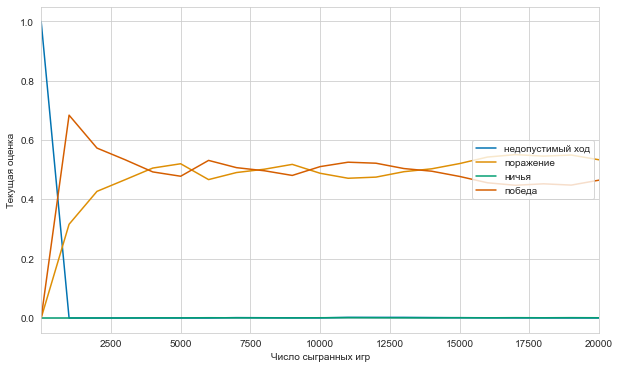

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(log_time, log_crash, label="недопустимый ход", color="C0")
ax.plot(log_time, log_lose, label="поражение", color="C1")
ax.plot(log_time, log_draw,  label="ничья", color="C2")
ax.plot(log_time, log_win, label="победа", color="C3")

ax.legend(loc="center right")
ax.set_xlim((1, max(log_time)+1))
ax.set_xlabel("Число сыгранных игр")
ax.set_ylabel("Текущая оценка")
#ax.set_ylim((-2, 4))

In [ ]:
Сеть учиться, но очень меделенно

In [20]:
# cеть v7
with open( "data\hw_2_task_net_10_10_soft_v7.pkl", "wb" ) as f:
    pickle.dump( net_model, f )
with open( "data\hw_2_task_net_10_10_soft_v7_log.pkl", "wb" ) as f:
    pickle.dump( (log_time, log_crash, log_lose, log_draw, log_win, log_rewards), f )

In [88]:
with open( "data\hw_2_task_net_10_10_soft_v7.pkl", "rb" ) as f:
    net_model = pickle.load(f)
with open( "data\hw_2_task_net_10_10_soft_v7_log.pkl", "rb" ) as f:
    log_time, log_crash, log_lose, log_draw, log_win, log_rewards = pickle.load(f)   

# Часть третья: расширим и углубим поиск

## rollouts

Реализуйте rollouts со случайной стратегией и (опционально) rollouts с
неслучайной, но простой стратегией (например, основанной на дополнении
нескольких паттернов или на Q-функции, которая у вас получилась в первом
пункте).

Для данного узла, сначала будем выбирать наилучшее действие с учетом неопределенности, а потом будем выбирать случайные ходы, до конца игры и добавляеть результат к оценки этого действия.

In [4]:
class Rollout_node():
    def __init__(self, action_id=-1, n=0, w=0):
        self.action_id = action_id
        self.n = n
        self.w = w
        self.child_actions = []
        

class Rollout():
    def __init__(self, env, steps = 1000, verbose = False):
        self.env = env
        self.steps = steps
        self.verbose = verbose
        
    def copy_state(self):    
        new_env = TicTacToe(n_rows=self.env.n_rows, n_cols=self.env.n_cols, n_win=self.env.n_win)
        new_env.board = self.env.board.copy()
        new_env.curTurn = self.env.curTurn
        return new_env

    def generate_next_random_action(self, env):

        board = env.board
        i = 0
        while True and  i < 10000:
            next_action_id = np.random.randint(NUMBER_ACTIONS)
            next_action_xy = self.get_action_by_id(next_action_id)
            
            if board[next_action_xy[0], next_action_xy[1]] == 0:
                break
            i += 1
            
        return next_action_id
    
    def get_action_by_id(self, action_id):

        return (action_id // self.env.n_rows, action_id % self.env.n_rows)
        
    
    def select_best_action(self, node):
        # выбор действия с учетом неопределенности
        # непросмотренные ходы имеют наибольший приоритет
        N_ALL = node.n
        def exp_rollout(pair):
            child_node = pair[1]       
            if child_node.n == 0:
                U = 100000 + random.randint(0, 100)
            else:
                U = child_node.w / child_node.n + 1.5 * sqrt(log(N_ALL) / child_node.n) 
            return U
    
        index_max_action = max(list(enumerate(node.child_actions)), key=exp_rollout)
        
        return index_max_action[0]
      
    def run_episode(self, next_action_id, cur_turn):
        # Случайно играем до конца игры
        step_env = self.copy_state()
        for _ in range(10000):
            observation, reward, done, info = step_env.step(self.get_action_by_id(next_action_id))

            if done:
                reward
                break
            next_action_id = self.generate_next_random_action(step_env)     
            cur_turn *= -1      
            
        return reward * cur_turn
     
    def run(self, env = None, steps = None):
        if env is not None:
            self.env = env  
            
        if steps is not None:
            self.steps = steps  
            
        base_node = Rollout_node()
        for action_id in range(NUMBER_ACTIONS):
            base_node.child_actions.append(Rollout_node(action_id))
        
        cur_turn = 1    
        for step in range(self.steps):
            next_action_id = self.select_best_action(base_node)
            w_last = self.run_episode(next_action_id, cur_turn)
            base_node.n += 1
            base_node.w += w_last
            base_node.child_actions[next_action_id].n += 1
            base_node.child_actions[next_action_id].w += w_last
        
        if self.verbose:
            for action_id in range(NUMBER_ACTIONS):
                V = base_node.child_actions[action_id].w / base_node.child_actions[action_id].n if base_node.child_actions[action_id].n > 0 else 10000
                action = self.get_action_by_id(action_id)
                print('action x:{:} y:{:}, number rollout: {:}, expectation: {:3.3f}'.format(
                    action[0], action[1], base_node.child_actions[action_id].n, 
                    V) )   

        # выбираем финально действие с наибольшей оценкой только из просмотренных ходов    
        index_max_action = max(list(enumerate(base_node.child_actions)), key=lambda x: x[1].w / x[1].n if x[1].n > 0 else -10000)[0]    

        if self.verbose:
            action = self.get_action_by_id(action_id)
            print('best action: {:}, {:}'.format(action[0], action[1]))
        return index_max_action
            

Проверка работы. Оценка состояний для игры 3 на 3.

In [8]:
NUMBER_ACTIONS = 3 * 3
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

In [22]:
mc_exp = Rollout(env, steps = 5000, verbose=True)
mc_exp.run()

action x:0 y:0, number rollout: 285, expectation: 0.309
action x:0 y:1, number rollout: 160, expectation: 0.219
action x:0 y:2, number rollout: 269, expectation: 0.301
action x:1 y:0, number rollout: 93, expectation: 0.118
action x:1 y:1, number rollout: 3367, expectation: 0.501
action x:1 y:2, number rollout: 105, expectation: 0.143
action x:2 y:0, number rollout: 152, expectation: 0.211
action x:2 y:1, number rollout: 83, expectation: 0.084
action x:2 y:2, number rollout: 486, expectation: 0.372
best action: 2, 2


4

### Игра используя rollout против стартегий

In [91]:
# Модификая модели
# За второго игрока будем выбирать ход используя rollout
class Deep_net_learning_runner_rollout(Deep_net_learning_runner_v2):
    def __init__(self, env, nn_model1, nn_model2, rollout2, total_episodes = 100000, gamma = 1.00, eps_value = 0.05, eps_value2 = 0.0, 
                 soft_exploration = False, delta_eps = 0.1, alpha_mean = 0.00001, 
                 off_policy = False, verbose = False, window_episodes = 100000, memory_size = 100000):
 
        super().__init__(env, nn_model1, nn_model2, total_episodes, gamma, eps_value, eps_value2, 
                 soft_exploration, delta_eps, alpha_mean, off_policy, verbose, window_episodes, memory_size)
        
        self.rollout2 = rollout2
        
    def generate_next_action(self, env, board, player, clear_expectation = True):
        
        if player == 1: # первый игрок
            state, next_action, clear_expectation = super().generate_next_action(env, board, player, clear_expectation)
        else:
            if np.random.rand() >= self.eps_value2 : 
                state = env.getState()
                next_action = self.rollout2.run(env = self.env, steps = self.steps)
                clear_expectation = False
            else: # random step 
                state, next_action, clear_expectation = super().generate_next_action(env, board, player, clear_expectation)
        
        return state, next_action, clear_expectation      
    
    def run(self, total_episodes = None, gamma = None, eps_value = None, eps_value2 = None, alpha_mean = None, 
            soft_exploration = None, delta_eps = None, verbose = None, memory_size = None, steps = 100):
        
        if env is not None:
            self.env = env  
            
        self.steps = steps         
        
        stats = super().run(total_episodes = total_episodes, gamma = gamma, eps_value = eps_value, eps_value2 = eps_value2, alpha_mean = alpha_mean, 
            soft_exploration = soft_exploration, delta_eps = delta_eps, verbose = verbose, memory_size = memory_size)  
        return stats 
     
            

In [27]:
# Окружение 5 на 5
NUMBER_ACTIONS = 5 * 5
env = TicTacToe(n_rows=5, n_cols=5, n_win=5)

In [61]:
# Загружаем обученную модель DQN
with open( "data\hw_2_task_net_5_5_3_v7.pkl", "rb" ) as f:
    net_model = pickle.load(f)

In [62]:
# Для проверки и оценки силы модели DQN: игра со случайной стратегией
st = net_model.run(total_episodes = 1000, eps_value = 0.00, eps_value2 = 1.00, soft_exploration = False, verbose = False)    

print("Всего игр: {:} из них побед: {:}, ничьих: {:}, поражений: {:}.".format(st[-1] + st[0] + st[1], st[1], st[0], st[-1]))
num_f = (st['f_-1'] + st['f_0'] + st['f_1']) / 100
print("За крестиков в % побед: {:3.1f}%, ничьих: {:3.1f}%, поражений: {:3.1f}%.".format(
    st['f_1'] / num_f, st['f_0'] / num_f, st['f_-1'] / num_f
))
num_s = (st['s_-1'] + st['s_0'] + st['s_1']) / 100
print("За ноликов в % побед: {:3.1f}%, ничьих: {:3.1f}%, поражений: {:3.1f}%.".format(
    st['s_1'] / num_s, st['s_0'] / num_s, st['s_-1'] / num_s
))

Всего игр: 987 из них побед: 482, ничьих: 461, поражений: 44.
За крестиков в % побед: 78.8%, ничьих: 15.7%, поражений: 5.5%.
За ноликов в % побед: 16.8%, ничьих: 79.9%, поражений: 3.4%.


В качестве второго игрока будет оценка на основе rollout из состояния

In [93]:
# Создаем модель с роллаутом и копируем обученную сеть в нее
model_rollout = Deep_net_learning_runner_rollout(env, copy.deepcopy(net_model.nnet1), copy.deepcopy(net_model.nnet1), 
                    rollout2 = Rollout(env), eps_value = 0.0, eps_value2 = 0.0, off_policy = True, memory_size = 500)

In [65]:
# rollout против случайной стратегии ()
st = model_rollout.run(total_episodes = 100, eps_value = 1.00, eps_value2 = 0.00, soft_exploration = False,  verbose = False)    
print("Всего игр: {:} из них побед: {:}, ничьих: {:}, поражений: {:}.".format(st[-1] + st[0] + st[1], st[-1], st[0], st[1]))

Всего игр: 100 из них побед: 83, ничьих: 17, поражений: 0.


In [124]:
# rollout против нейросети обученной dqn
st = model_rollout.run(total_episodes = 100, eps_value = 0.00, eps_value2 = 0.00, soft_exploration = True, delta_eps = 0.01, verbose = False)    
print("Всего игр: {:} из них побед: {:}, ничьих: {:}, поражений: {:}.".format(st[-1] + st[0] + st[1], st[-1], st[0], st[1]))

Всего игр: 100 из них побед: 50, ничьих: 45, поражений: 5.


In [150]:
# Зависимоть силы игры от числа итераций (для каждого действия есть как миниму одна)
# rollout против случайной стратегии
for steps in [3, 10, 30, 100, 300, 1000]:
    st = model_rollout.run(steps = steps, total_episodes = 100, eps_value = 1.00, eps_value2 = 0.00, soft_exploration = False,  verbose = False)
    print("Rollout steps {:}, игр: {:} из них побед: {:}, ничьих: {:}, поражений: {:}.".format(steps, st[-1] + st[0] + st[1], st[-1], st[0], st[1]))

Rollout steps 3, игр: 98 из них побед: 60, ничьих: 34, поражений: 4.
Rollout steps 10, игр: 100 из них побед: 68, ничьих: 28, поражений: 4.
Rollout steps 30, игр: 98 из них побед: 77, ничьих: 21, поражений: 0.
Rollout steps 100, игр: 100 из них побед: 83, ничьих: 17, поражений: 0.
Rollout steps 300, игр: 99 из них побед: 90, ничьих: 9, поражений: 0.
Rollout steps 1000, игр: 100 из них побед: 95, ничьих: 5, поражений: 0.


In [129]:
# Зависимоть силы игры от числа итераций (для каждого действия есть как миниму одна)
# rollout против нейросети обученной dqn
for steps in [3, 10, 30, 100, 300, 1000]:
    st = model_rollout.run(steps = steps, total_episodes = 100, eps_value = 0.00, eps_value2 = 0.00, soft_exploration = True, delta_eps = 0.01,  verbose = False)
    print("Rollout steps {:}, игр: {:} из них побед: {:}, ничьих: {:}, поражений: {:}.".format(steps, st[1] + st[0] + st[-1], st[-1], st[0], st[1]))

Rollout steps 3, игр: 100 из них побед: 12, ничьих: 51, поражений: 37.
Rollout steps 10, игр: 100 из них побед: 29, ничьих: 42, поражений: 29.
Rollout steps 30, игр: 100 из них побед: 28, ничьих: 47, поражений: 25.
Rollout steps 100, игр: 100 из них побед: 41, ничьих: 44, поражений: 15.
Rollout steps 300, игр: 100 из них побед: 56, ничьих: 42, поражений: 2.
Rollout steps 1000, игр: 100 из них побед: 75, ничьих: 25, поражений: 0.


In [151]:
# Зависимоть силы игры от числа итераций (для каждого действия есть как миниму одна)
# rollout против нейросети обученной dqn
for steps in [3, 10, 30, 100, 300, 1000]:
    st = model_rollout.run(steps = steps, total_episodes = 100, eps_value = 0.00, eps_value2 = 0.00, soft_exploration = True, delta_eps = 0.01,  verbose = False)
    print("Rollout steps {:}, игр: {:} из них побед: {:}, ничьих: {:}, поражений: {:}.".format(steps, st[1] + st[0] + st[-1], st[-1], st[0], st[1]))

Rollout steps 3, игр: 100 из них побед: 16, ничьих: 36, поражений: 48.
Rollout steps 10, игр: 100 из них побед: 19, ничьих: 49, поражений: 32.
Rollout steps 30, игр: 100 из них побед: 27, ничьих: 53, поражений: 20.
Rollout steps 100, игр: 100 из них побед: 40, ничьих: 52, поражений: 8.
Rollout steps 300, игр: 100 из них побед: 56, ничьих: 42, поражений: 2.
Rollout steps 1000, игр: 100 из них побед: 71, ничьих: 29, поражений: 0.


In [94]:
# Зависимоть силы игры от числа итераций (для каждого действия есть как миниму одна)
# rollout против нейросети обученной dqn
for steps in [3, 5, 10, 20, 30, 40, 50]:
    st = model_rollout.run(steps = steps, total_episodes = 100, eps_value = 0.00, eps_value2 = 0.00, soft_exploration = True, delta_eps = 0.01,  verbose = False)
    print("Rollout steps {:}, игр: {:} из них побед: {:}, ничьих: {:}, поражений: {:}.".format(steps, st[10] + st[1] + st[0] + st[-1], st[-1] , st[0], st[1] + st[10]))

Rollout steps 3, игр: 100 из них побед: 2, ничьих: 2, поражений: 96.
Rollout steps 5, игр: 100 из них побед: 6, ничьих: 6, поражений: 88.
Rollout steps 10, игр: 100 из них побед: 11, ничьих: 19, поражений: 70.
Rollout steps 20, игр: 100 из них побед: 13, ничьих: 29, поражений: 58.
Rollout steps 30, игр: 100 из них побед: 24, ничьих: 51, поражений: 25.
Rollout steps 40, игр: 100 из них побед: 26, ничьих: 53, поражений: 21.
Rollout steps 50, игр: 100 из них побед: 27, ничьих: 48, поражений: 25.


Для игры 5 на 5 выбор хода на основе rollout дает заметно лучший результат, чем модель DQN

## Monte Carlo tree search

Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного
размера, сравните полученные стратегии между собой и со стратегиями,
обученными в первых двух частях

In [24]:
class Node():
    def __init__(self, sid, player, parent_id=None, action_id=-1, level=0, n=0, w=0): #action_id=-1,
        self.sid = sid
        self.parent_id = parent_id
        self.player = player # за кого этот ход 1 за себя,0 за соперника
        self.action_id = action_id
        self.n = n
        self.w = w
        self.child_nodes = []
        self.level = level
        
    def add_child(self):
        for action_id in range(NUMBER_ACTIONS):
            self.child_nodes.append(Node(self.sid + "_" + str(action_id), -1*self.player, parent_id=self, action_id=action_id, level=self.level+1))

class MCTS():
    def __init__(self, env, steps = 1000, max_level = 100, verbose = False):
        self.env = env
        self.steps = steps
        self.verbose = verbose
        self.max_level = max_level # максимальная глубина
        
    def copy_state(self):    
        new_env = TicTacToe(n_rows=self.env.n_rows, n_cols=self.env.n_cols, n_win=self.env.n_win)
        new_env.board = self.env.board.copy()
        new_env.curTurn = self.env.curTurn
        return new_env

    def generate_next_random_action(self, env):

        board = env.board
        i = 0
        while True and  i < 10000:
            next_action_id = np.random.randint(NUMBER_ACTIONS)
            next_action_xy = self.get_action_by_id(next_action_id)
            
            if board[next_action_xy[0], next_action_xy[1]] == 0:
                break
            i += 1
            
        return next_action_id
    
    def get_action_by_id(self, action_id):

        return (action_id // self.env.n_rows, action_id % self.env.n_rows)
        
    
    def select_best_action(self, node):
        
        N_ALL = node.n
        def exp_rollout(pair):
            child_node = pair[1]       
            if child_node.n == 0:
                U = 100000 + random.randint(0, 100)
            else:
                U = child_node.w / child_node.n + 1.5 * sqrt(log(N_ALL) / child_node.n) 
            return U
    
        index_max_action = max(list(enumerate(node.child_nodes)), key=exp_rollout)
        
        return index_max_action[0], node.child_nodes[index_max_action[0]]
      
    def run_episode(self, step_env, cur_turn):
        
        if self.env.isTerminal():
            return 0, True
        
        for _ in range(10000):
            next_action_id = self.generate_next_random_action(step_env) 
            observation, reward, done, info = step_env.step(self.get_action_by_id(next_action_id))

            if done:
                reward
                break
                
            cur_turn *= -1      
            
        return reward * cur_turn, False
     
    def run(self, env = None, steps = None, max_level = None):
        if env is not None:
            self.env = env     
        if steps is not None:
            self.steps = steps  
        if max_level is not None:
            self.max_level = max_level      
            
        base_node = Node("r", -1)
        base_node.add_child()
        
        
        cur_turn = self.env.curTurn #за кого считаем очки в состоянии 
 
        for step in range(self.steps):
            #print('step', step)
            step_env = self.copy_state()
            node = base_node
            while True:
                next_action_id, new_node = self.select_best_action(node)
                observation, reward, done, info = step_env.step(self.get_action_by_id(next_action_id))
                node = new_node
                if len(new_node.child_nodes)==0 or done or new_node.level >= self.max_level:
                    break               
                    
            # expand
            if len(new_node.child_nodes)==0 and new_node.level < self.max_level:
                node.add_child()
                

            
            # Simulation
            if not done:
                w_last, done = self.run_episode(step_env, cur_turn)  
                w_last = -1 * w_last * self.env.curTurn   # знак награды в листе        
            else:
                w_last = reward
            
            #print('Simulation w_last: {:}'.format(w_last))    

            # Backpropagation - проставляем результаты выше по дереву
            while True:
                node.n += 1
                node.w += w_last
                if node.parent_id == None:
                    break
                    
                node = node.parent_id
                if abs(w_last) > 1:
                    w_last = int(w_last/10) # недопустиный ход транслируем как проигрыш
                w_last = -1 * w_last
                
            if self.verbose:
                self.print_tree(base_node)
        
        if self.verbose:
            for action_id in range(NUMBER_ACTIONS):
                V = base_node.child_nodes[action_id].w / base_node.child_nodes[action_id].n if base_node.child_nodes[action_id].n > 0 else 10000
                print('id: {:}, n: {:}, w: {:3.3f}'.format(
                    action_id, base_node.child_nodes[action_id].n, 
                    V) )   

        # выбираем только из просмотренных ходов    
        index_max_action = max(list(enumerate(base_node.child_nodes)), key=lambda x: x[1].w / x[1].n if x[1].n > 0 else -10000)[0]    

        if self.verbose:
            self.print_tree(base_node)
                
        if self.verbose:
            print('best action: {:}'.format(index_max_action))
        return index_max_action
    
    def print_tree(self, node):
        print("Tree")
        self.print_node(node)    
        
    def print_node(self, node):   
        if node.n > 0:
            print(" ".join([" "] *node.level), " s: {:} a_id: {:} w: {:} n: {:} w/n {:3.2f} player: {:}".format(node.sid, node.action_id, node.w, node.n, node.w/(0.000001 +node.n), node.player))
        for child in node.child_nodes:
            self.print_node(child) 
        

In [25]:
mcts_exp = MCTS(env, steps = 1115, max_level=4, verbose=False)
mcts_exp.run()

4

In [475]:
# Тестируем игру MCTS
# Окружение 5 на 5
NUMBER_ACTIONS = 5 * 5
env = TicTacToe(n_rows=5, n_cols=5, n_win=5)

In [300]:
# Создаем модель с роллаутом и копируем обученную сеть в нее
model_mcts = Deep_net_learning_runner_rollout(env, copy.deepcopy(net_model.nnet1), copy.deepcopy(net_model.nnet1), 
                    rollout2 = MCTS(env, steps = 100, max_level = 1), eps_value = 0.0, eps_value2 = 0.0, off_policy = True, memory_size = 500)

In [301]:
# MCTS против случайной стратегии ()
st = model_mcts.run(total_episodes = 100, eps_value = 1.00, eps_value2 = 0.00, soft_exploration = False,  verbose = False)    
print("Всего игр: {:} из них побед: {:}, ничьих: {:}, поражений: {:}.".format(steps, st[10] + st[1] + st[0] + st[-1], st[-1] , st[0], st[1] + st[10]))


Всего игр: 100 из них побед: 83, ничьих: 17, поражений: 0.


In [302]:
# rollout против нейросети обученной dqn
st = model_mcts.run(total_episodes = 100, eps_value = 0.00, eps_value2 = 0.00, soft_exploration = True, delta_eps = 0.01, verbose = False)    
print("Всего игр: {:} из них побед: {:}, ничьих: {:}, поражений: {:}.".format(steps, st[10] + st[1] + st[0] + st[-1], st[-1] , st[0], st[1] + st[10]))

Всего игр: 100 из них побед: 44, ничьих: 40, поражений: 16.


In [304]:
# Зависимоть силы игры от числа итераций (для каждого действия есть как миниму одна)
# rollout против случайной стратегии
for steps in [3, 10, 30, 100, 300, 1000]:
    st = model_mcts.run(steps = steps, total_episodes = 100, eps_value = 1.00, eps_value2 = 0.00, soft_exploration = False,  verbose = False)
    print("Rollout steps {:}, игр: {:} из них побед: {:}, ничьих: {:}, поражений: {:}.".format(steps, st[10] + st[1] + st[0] + st[-1], st[-1] , st[0], st[1] + st[10]))

Rollout steps 3, игр: 100 из них побед: 4, ничьих: 1, поражений: 95.
Rollout steps 10, игр: 100 из них побед: 30, ничьих: 18, поражений: 52.
Rollout steps 30, игр: 100 из них побед: 71, ничьих: 25, поражений: 4.
Rollout steps 100, игр: 100 из них побед: 81, ничьих: 19, поражений: 0.
Rollout steps 300, игр: 100 из них побед: 87, ничьих: 13, поражений: 0.
Rollout steps 1000, игр: 100 из них побед: 93, ничьих: 7, поражений: 0.


In [305]:
# Зависимоть силы игры от числа итераций (для каждого действия есть как миниму одна)
# rollout против нейросети обученной dqn
for steps in [3, 5, 10, 20, 30, 40, 50, 100, 300, 1000]:
    st = model_mcts.run(steps = steps, total_episodes = 100, eps_value = 0.00, eps_value2 = 0.00, soft_exploration = True, delta_eps = 0.01,  verbose = False)
    print("Rollout steps {:}, игр: {:} из них побед: {:}, ничьих: {:}, поражений: {:}.".format(steps, st[10] + st[1] + st[0] + st[-1], st[-1] , st[0], st[1] + st[10]))

Rollout steps 3, игр: 100 из них побед: 0, ничьих: 0, поражений: 100.
Rollout steps 5, игр: 100 из них побед: 8, ничьих: 4, поражений: 88.
Rollout steps 10, игр: 100 из них побед: 2, ничьих: 17, поражений: 81.
Rollout steps 20, игр: 100 из них побед: 14, ничьих: 42, поражений: 44.
Rollout steps 30, игр: 100 из них побед: 17, ничьих: 52, поражений: 31.
Rollout steps 40, игр: 100 из них побед: 28, ничьих: 39, поражений: 33.
Rollout steps 50, игр: 100 из них побед: 27, ничьих: 53, поражений: 20.
Rollout steps 100, игр: 100 из них побед: 43, ничьих: 37, поражений: 20.
Rollout steps 300, игр: 100 из них побед: 58, ничьих: 38, поражений: 4.
Rollout steps 1000, игр: 100 из них побед: 67, ничьих: 33, поражений: 0.


In [306]:
model_mcts = Deep_net_learning_runner_rollout(env, copy.deepcopy(net_model.nnet1), copy.deepcopy(net_model.nnet1), 
                    rollout2 = MCTS(env, steps = 100, max_level = 3), eps_value = 0.0, eps_value2 = 0.0, off_policy = True, memory_size = 500)

In [307]:
# Зависимоть силы игры от числа итераций (для каждого действия есть как миниму одна)
# rollout против случайной стратегии
for steps in [3, 10, 30, 100, 300, 1000]:
    st = model_mcts.run(steps = steps, total_episodes = 100, eps_value = 1.00, eps_value2 = 0.00, soft_exploration = False,  verbose = False)
    print("Rollout steps {:}, игр: {:} из них побед: {:}, ничьих: {:}, поражений: {:}.".format(steps, st[10] + st[1] + st[0] + st[-1], st[-1] , st[0], st[1] + st[10]))

Rollout steps 3, игр: 100 из них побед: 6, ничьих: 0, поражений: 94.
Rollout steps 10, игр: 100 из них побед: 38, ничьих: 14, поражений: 48.
Rollout steps 30, игр: 99 из них побед: 8, ничьих: 77, поражений: 14.
Rollout steps 100, игр: 98 из них побед: 6, ничьих: 64, поражений: 28.
Rollout steps 300, игр: 100 из них побед: 28, ничьих: 50, поражений: 22.
Rollout steps 1000, игр: 99 из них побед: 43, ничьих: 41, поражений: 15.


In [478]:
# Зависимоть силы игры от числа итераций (для каждого действия есть как миниму одна)
# rollout против случайной стратегии
#for level in [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]:
for level in [1, 2, 3, 4, 5]:
    model_mcts = Deep_net_learning_runner_rollout(env, copy.deepcopy(net_model.nnet1), copy.deepcopy(net_model.nnet1), 
                    rollout2 = MCTS(env, steps = 100, max_level = level), eps_value = 0.0, eps_value2 = 0.0, off_policy = True, memory_size = 500)
    st = model_mcts.run(steps = 1000, total_episodes = 100, eps_value = 1.00, eps_value2 = 0.00, soft_exploration = False,  verbose = False)
    print("Rollout level {:}, игр: {:} из них побед: {:}, ничьих: {:}, поражений: {:}.".format(level, st[10] + st[1] + st[0] + st[-1], st[-1] , st[0], st[1] + st[10]))

Rollout level 1, игр: 100 из них побед: 95, ничьих: 5, поражений: 0.
Rollout level 2, игр: 100 из них побед: 94, ничьих: 6, поражений: 0.
Rollout level 3, игр: 100 из них побед: 89, ничьих: 11, поражений: 0.
Rollout level 4, игр: 100 из них побед: 91, ничьих: 9, поражений: 0.
Rollout level 5, игр: 100 из них побед: 89, ничьих: 11, поражений: 0.
